This project aims to develop an intelligent system capable of detecting pneumonia from chest X-ray images. Pneumonia is particularly challenging to diagnose accurately using traditional methods. Therefore, an automated and reliable detection system could improve diagnostic efficiency and patient outcomes.

This project will utilize the dataset available on Kaggle Chest X-ray Images (Pneumonia), which contains chest X-ray images classified into two categories: Normal and Pneumonia. The primary objectives of this project are to explore and preprocess this dataset, develop detection algorithms using both classical machine learning and neural network techniques, and evaluate the performance of these algorithms.

The workflow of the project is structured as follows:
1. Data Exploration: The dataset will be explored to understand the distribution and characteristics of the images.
2. Data Visualization and Preprocessing: Visualization techniques will be employed to gain insights into the dataset. Preprocessing steps, such as augmentation, and features extraction will be applied to prepare the images for algorithm development.
3. Algorithm Development: \
Classical Machine Learning Techniques: Features will be extracted from the images, and classical machine learning algorithms, such as Support Vector Machines (SVM) and Random Forests, will be employed for pneumonia detection. \
Neural Network Architecture: We will explore a range of neural network models, starting with simple networks and progressing to convolutional neural networks (CNNs) and transfer learning approaches. This will allow us to assess the effectiveness and advantages of each model compared to classical machine learning techniques.

4. Results Presentation: The performance of the developed algorithms will be evaluated using metrics such as confusion matrix. These results will be analyzed to determine the effectiveness of each approach in detecting pneumonia from chest X-ray images. For evaluating models that detect pneumonia from medical images, we focus on four critical metrics:
* Recall for Pneumonia: Measures how well the model identifies pneumonia cases. High recall is essential to avoid missing actual pneumonia patients.
* Precision for Normal: Assesses how accurately the model identifies normal cases. High precision reduces false positives, ensuring healthy individuals are correctly classified.
* Overall Accuracy: Provides a general measure of how often the model is correct. It gives a broad view but can be misleading in imbalanced datasets.
* F1-Score: Balances precision and recall, offering a single metric to gauge the model's effectiveness in both identifying pneumonia and avoiding false positives.

By completing this project, we aim to provide a comparative analysis of different techniques for pneumonia detection.

In [65]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
import tensorflow as tf
import cv2
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from skimage import exposure
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from dask import delayed, compute
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, confusion_matrix
from tqdm.notebook import tqdm
import time


Set paths to train, vlaidation and test datasets

In [2]:
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'
val_dir = 'chest_xray/val'

# Data Analysis

1. Load Images into a DataFrame
2. Convert images to arrays and store them in a DataFrame with labels.

In [3]:
def load_images_to_df(directory, image_shape=(128, 128), color_mode=cv2.IMREAD_GRAYSCALE):
    data = []
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, color_mode)  # Load image
            img = cv2.resize(img, image_shape)  # Resize to specified shape
            img = img.flatten()  # Flatten image array
            data.append([img, class_name])
    
    df = pd.DataFrame(data, columns=['image', 'label'])
    return df

train_df = load_images_to_df(train_dir)
val_df = load_images_to_df(val_dir)
test_df = load_images_to_df(test_dir)

display(train_df.head())
display(val_df.head())
display(test_df.head())

,image,label
0,"[13, 123, 255, 4, 1, 43, 255, 22, 29, 29, 31, ...",PNEUMONIA
1,"[53, 61, 62, 62, 67, 67, 65, 67, 115, 104, 95,...",PNEUMONIA
2,"[0, 4, 6, 9, 251, 17, 21, 253, 38, 53, 59, 67,...",PNEUMONIA
3,"[79, 86, 96, 104, 108, 163, 164, 163, 174, 159...",PNEUMONIA
4,"[20, 19, 21, 21, 20, 21, 21, 19, 17, 17, 16, 1...",PNEUMONIA


,image,label
0,"[0, 0, 0, 0, 0, 0, 1, 40, 1, 15, 17, 20, 25, 2...",PNEUMONIA
1,"[2, 2, 1, 1, 1, 0, 243, 254, 2, 10, 11, 14, 15...",PNEUMONIA
2,"[63, 64, 63, 62, 64, 52, 253, 59, 64, 61, 62, ...",PNEUMONIA
3,"[0, 1, 13, 27, 28, 37, 53, 75, 87, 96, 103, 10...",PNEUMONIA
4,"[11, 255, 33, 252, 61, 73, 88, 101, 105, 111, ...",PNEUMONIA


,image,label
0,"[80, 85, 80, 82, 84, 86, 94, 94, 100, 103, 93,...",PNEUMONIA
1,"[0, 4, 9, 17, 22, 255, 34, 49, 169, 76, 86, 93...",PNEUMONIA
2,"[158, 156, 126, 180, 119, 156, 139, 141, 166, ...",PNEUMONIA
3,"[37, 37, 38, 43, 46, 44, 48, 51, 59, 62, 63, 6...",PNEUMONIA
4,"[22, 21, 25, 255, 34, 38, 253, 54, 63, 74, 87,...",PNEUMONIA


Lets take a look on our datasets.

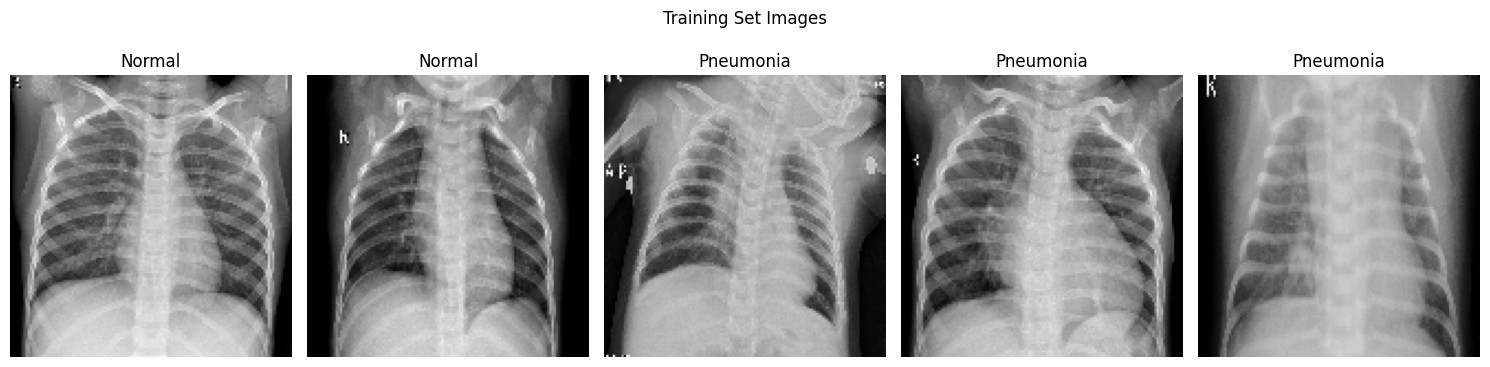

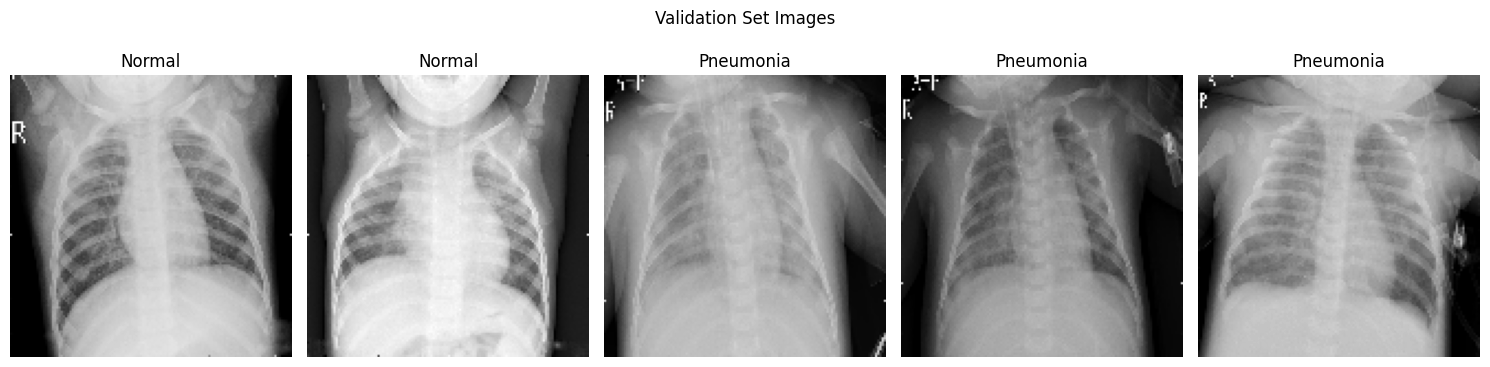

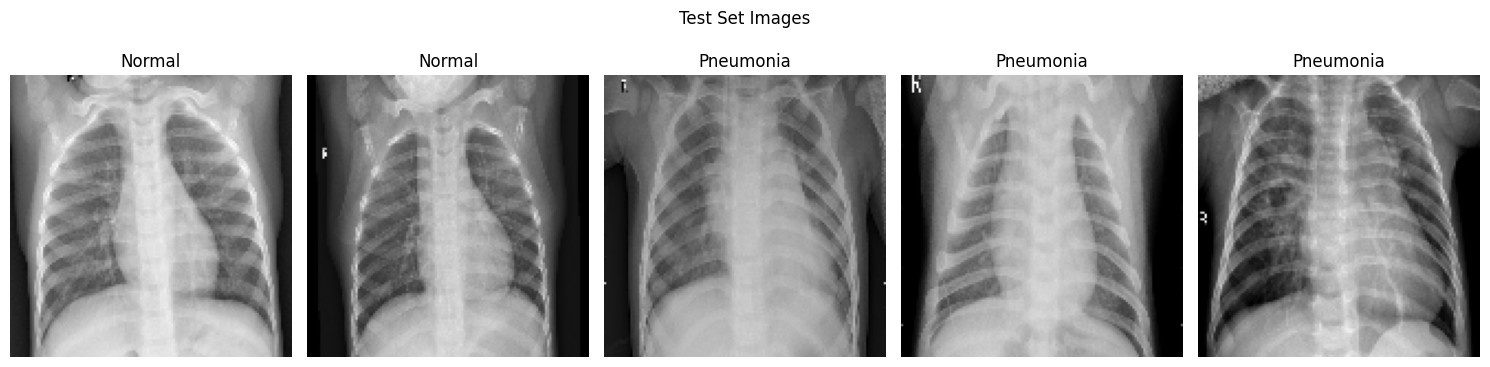

In [4]:
def plot_images_from_df(df, title, num_images=5):
    normal_num_images = num_images//2
    penumonia_num_images = num_images - normal_num_images
    normal_images = df[df['label'] == 'NORMAL']['image'].to_list()[:normal_num_images]
    pneumonia_images = df[df['label'] == 'PNEUMONIA']['image'].to_list()[:penumonia_num_images]
    selected_images = normal_images+pneumonia_images

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        if i < normal_num_images:
            label = 'Normal'
        else:
            label = 'Pneumonia' 
        img = selected_images[i].reshape(128, 128)  # Reshape to 2D
        
        plt.subplot(1, num_images, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0, 1, 1.2])  
    plt.show()

plot_images_from_df(train_df, 'Training Set Images')
plot_images_from_df(val_df, 'Validation Set Images')
plot_images_from_df(test_df, 'Test Set Images')

Count and plot class distribution for train, valid, test datasets.

Total images in Given Training Set Class Distribution:
label
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64



/tmp/ipykernel_83614/1285011510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


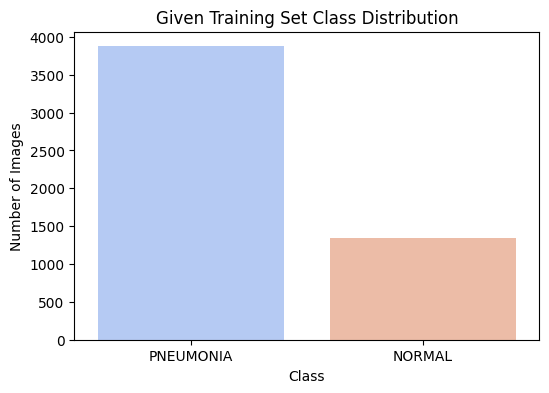

Total images in Given Validation Set Class Distribution:
label
PNEUMONIA    8
NORMAL       8
Name: count, dtype: int64



/tmp/ipykernel_83614/1285011510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


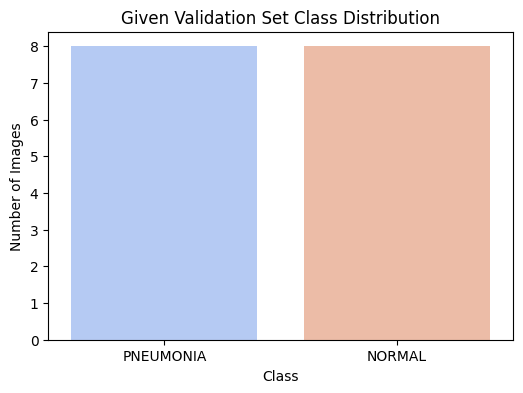

Total images in Given Test Set Class Distribution:
label
PNEUMONIA    390
NORMAL       234
Name: count, dtype: int64



/tmp/ipykernel_83614/1285011510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


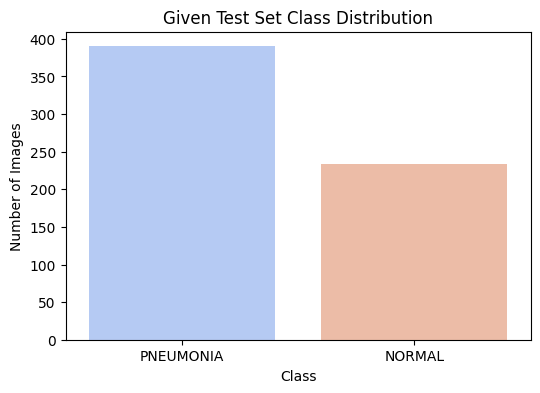

In [5]:
def count_and_plot_distribution(df, title):
    class_counts = df['label'].value_counts()
    
    print(f"Total images in {title}:")
    print(class_counts)
    print()
    
    plt.figure(figsize=(6, 4))
    sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Number of Images')
    plt.show()

count_and_plot_distribution(train_df, 'Given Training Set Class Distribution')
count_and_plot_distribution(val_df, 'Given Validation Set Class Distribution')
count_and_plot_distribution(test_df, 'Given Test Set Class Distribution')


We observe that our training and test datasets are imbalanced, with a higher proportion of pneumonia records. To address this imbalance in the training dataset, we will apply several techniques because achieving balanced data is crucial for:

Model Performance: Imbalanced data can lead to biased models that favor the majority class, reducing the accuracy and reliability of predictions, particularly for the minority class. Balancing the data helps ensure the model performs well across all classes.

Avoiding Overfitting: Models trained on imbalanced data might overfit to the majority class, capturing noise rather than meaningful patterns. Balancing techniques can help the model generalize better to unseen data.

Improved Sensitivity: In medical diagnoses like pneumonia detection, it is essential to minimize false negatives (missed diagnoses). Balanced datasets improve the model's sensitivity to detecting pneumonia cases.

Fair Evaluation: Using balanced data allows for a more accurate evaluation of model performance across different classes, providing a clearer understanding of how the model behaves in real-world scenarios.

Moreover given that the validation is too small to validate our models, we will increase it by moving some records from the training to the validation set

# Preprocessing

## Increase the Validation Dataset

We increase the very small validation dataset by appending the 10% of the training dataset to that and at the same time decreasing the training dataset using stratify. This will lead to imbalance validation dataset as the straitify ensures to have same proportion wrt the records of each class in both training and validation datasets. However in many real-world scenarios, data is imbalanced. Having an imbalanced validation set can provide a more realistic evaluation of the model’s performance and increasing its size will make the validation process more reliable.

In [6]:
le = LabelEncoder()
le.fit(train_df['label'])

LabelEncoder()

In [7]:
train_df['label'] = le.transform(train_df['label'])
val_df['label'] = le.transform(val_df['label'])

# We want to have 10% percentage as validation (as we do not have many data neither for training) and 90% as training
# we split the data using stratif so that to have same proportion to bo
X_train_new, X_val_new, y_train_new, y_val_new = train_test_split(
    train_df['image'], train_df['label'], test_size=0.1, random_state=42, stratify=train_df['label']
)

train_df = pd.DataFrame({'image': X_train_new, 'label': y_train_new})
new_val_df = pd.DataFrame({'image': X_val_new, 'label': y_val_new})

# Concatenate the new validation set with the existing validation set
val_df = pd.concat([val_df, new_val_df], ignore_index=True)

train_df['label'] = le.inverse_transform(train_df['label'])
val_df['label'] = le.inverse_transform(val_df['label'])

Total images in Rearranged Training Set Class Distribution:
label
PNEUMONIA    3487
NORMAL       1207
Name: count, dtype: int64



/tmp/ipykernel_83614/1285011510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


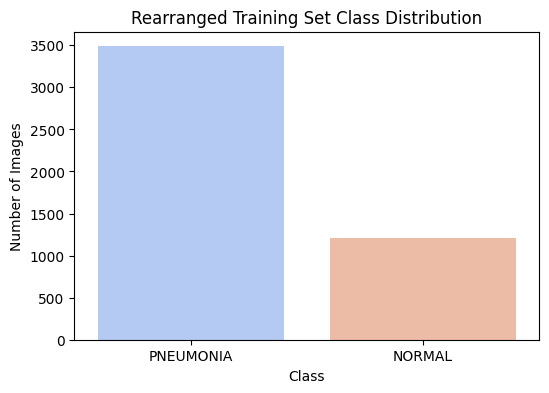

Total images in Rearranged Validation Set Class Distribution:
label
PNEUMONIA    396
NORMAL       142
Name: count, dtype: int64



/tmp/ipykernel_83614/1285011510.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette='coolwarm')


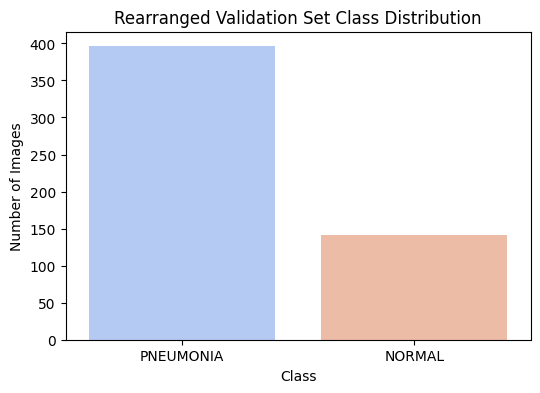

In [8]:
count_and_plot_distribution(train_df, 'Rearranged Training Set Class Distribution')
count_and_plot_distribution(val_df, 'Rearranged Validation Set Class Distribution')

Our validation set size has been increased.

## Data Augmentation

In this section, we apply data augmentation techniques to address class imbalance by generating new training examples for the minority class. These techniques enhance the diversity of the training dataset. However we avoid random rotations and reflections along the x-axis to prevent creating unrealistic images that might mislead the model.

The ImageDataGenerator in Keras is configured to apply the following augmentations:

Zoom Range: zoom_range=0.2
This parameter allows random zooming of images within the specified range (±20%). It simulates variations in the distance from the subject, enhancing the model’s ability to recognize objects at different scales.

Width Shift Range: width_shift_range=0.2
This parameter shifts images horizontally by up to 20% of the width. It makes the model more robust to variations in the position of pneumonia symptoms in x-rays.

Height Shift Range: height_shift_range=0.2
Similar to width shift, this parameter shifts images vertically by up to 20% of the height. It improves the model’s robustness to vertical translations, accommodating variations in the vertical positioning of the features of interest.

Brightness Range: brightness_range=[0.8, 1.2]
This parameter adjusts the brightness of images randomly within the specified range (80% to 120% of the original brightness). It simulates different lighting conditions, helping the model handle variations in image exposure.

Fill Mode: fill_mode='nearest'
This parameter determines how to fill in new pixels created by transformations like shifts. Using the ‘nearest’ mode, it fills these pixels by replicating the nearest pixel value, preserving the visual consistency of the augmented image.

In [9]:
# Random rotation and reflection along the x-axis are not recommended
# as they can create unrealistic images that might mislead the model
datagen = ImageDataGenerator(
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

def augment_images(df, minority_class, num_samples):
    minority_df = df[df['label'] == minority_class]
    augmented_images = []
    minority_images = minority_df['image'].values  # Get minority class images
    num_minority_images = len(minority_images)  # Number of minority class images
    
    # Use tqdm for the progress bar
    for i in tqdm(range(num_samples), desc="Augmenting Images"):
        index = i % num_minority_images  # Cycle through minority images
        img_flatten = minority_images[index]
        img = img_flatten.reshape(128, 128, 1)  # Reshape for augmentation
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        aug_iter = datagen.flow(img, batch_size=1)
        aug_img = next(aug_iter)[0]
        augmented_images.append([aug_img.reshape(-1), minority_class])

    return pd.DataFrame(augmented_images, columns=['image', 'label'])

In [10]:
class_counts = train_df['label'].value_counts()
diff_pneum_norm = class_counts['PNEUMONIA'] - class_counts['NORMAL']
print(f"Before augmentation total pneumonia records: {class_counts['PNEUMONIA']}, total normal records: {class_counts['NORMAL']} in the training dataset")

augmented_minority_df = augment_images(train_df, minority_class='NORMAL', num_samples=diff_pneum_norm)
train_df_augmented = pd.concat([train_df, augmented_minority_df])

total_pneu = train_df_augmented[train_df_augmented["label"] == 'PNEUMONIA'].shape[0]
class_counts = train_df_augmented['label'].value_counts()
print(f"After augmentation total pneumonia records: {class_counts['PNEUMONIA']}, total normal records: {class_counts['NORMAL']} in the training dataset")

Before augmentation total pneumonia records: 3487, total normal records: 1207 in the training dataset


Augmenting Images:   0%|          | 0/2280 [00:00<?, ?it/s]

After augmentation total pneumonia records: 3487, total normal records: 3487 in the training dataset


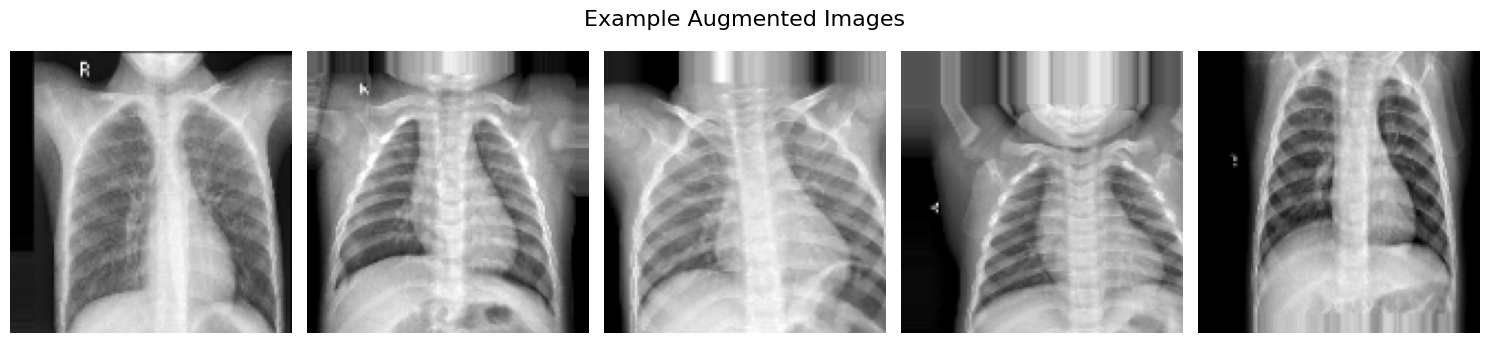

In [11]:
augmented_images = augmented_minority_df.head(5)['image'].to_numpy()
plt.figure(figsize=(15, 5)) 

plt.suptitle('Example Augmented Images', fontsize=16)  

for i, img_flatten in enumerate(augmented_images):
    img = img_flatten.reshape((128, 128))
    plt.subplot(1, 5, i + 1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 1.3])  
plt.show()

## Downsample

Another way to address imbalance is downsampling, a technique with which we reduce the number of samples in the majority class so that it matches the size of the minority class. This ensures that the training data has an equal representation of each class, preventing the model from being biased towards the majority class

In [12]:
train_df_majority = train_df[train_df["label"] == 'PNEUMONIA']
train_df_minority = train_df[train_df["label"] == 'NORMAL']

print(f"Before downsampling total pneumonia records: {len(train_df_majority)}, total normal records: {len(train_df_minority)}")
# Downsample majority class
df_majority_downsampled = resample(train_df_majority,
                                   replace=False,  
                                   n_samples=len(train_df_minority), 
                                   random_state=42)  

train_df_downsampled = pd.concat([train_df_minority, df_majority_downsampled])

total_pneu = train_df_downsampled[train_df_downsampled["label"] == 'PNEUMONIA'].shape[0]
total_norm = train_df_downsampled[train_df_downsampled["label"] == 'NORMAL'].shape[0]
print(f"After downsampling total pneumonia records: {total_pneu}, total normal records: {total_norm}")

Before downsampling total pneumonia records: 3487, total normal records: 1207
After downsampling total pneumonia records: 1207, total normal records: 1207


Finally we apply image rescaling, a preprocessing step where the pixel values of images are scaled to a range between 0 and 1. This normalization technique is crucial for improving the performance and stability of machine learning models, particularly neural networks. 

In [13]:
def rescale_images(df):
    df['image'] = df['image'].apply(lambda img: img / 255.0)
    return df

train_df = rescale_images(train_df)
train_df_augmented = rescale_images(train_df_augmented)
train_df_downsampled = rescale_images(train_df_downsampled)
val_df = rescale_images(val_df)
test_df = rescale_images(test_df)

## Features Extraction

In this section, we focus on extracting features from images to facilitate the classification task. Specifically, we employ two methods: Histogram of Oriented Gradients (HOG) and pixel intensity histograms. These methods convert image data into numerical features that capture essential characteristics, making them suitable for machine learning models.

In [14]:
X_train = np.stack(train_df['image'].values)
train_df['label'] = le.transform(train_df['label'])
y_train = train_df['label'].values

X_train_augmented = np.stack(train_df_augmented['image'].values)
train_df_augmented['label'] = le.transform(train_df_augmented['label'])
y_train_augmented = train_df_augmented['label'].values

X_train_downsampled = np.stack(train_df_downsampled['image'].values)
train_df_downsampled['label'] = le.transform(train_df_downsampled['label'])
y_train_downsampled = train_df_downsampled['label'].values

X_val = np.stack(val_df['image'].values)
val_df['label'] = le.transform(val_df['label'])
y_val = val_df['label'].values

X_test = np.stack(test_df['image'].values)
test_df['label'] = le.transform(test_df['label'])
y_test = test_df['label'].values

### HOG

The Histogram of Oriented Gradients (HOG) method extracts features based on the gradient orientation and magnitude in localized regions of the image. This technique is effective for capturing the structural information in images, such as edges and textures, which are crucial for distinguishing between different classes. Below is an example hog visualization of an image of the dataset.

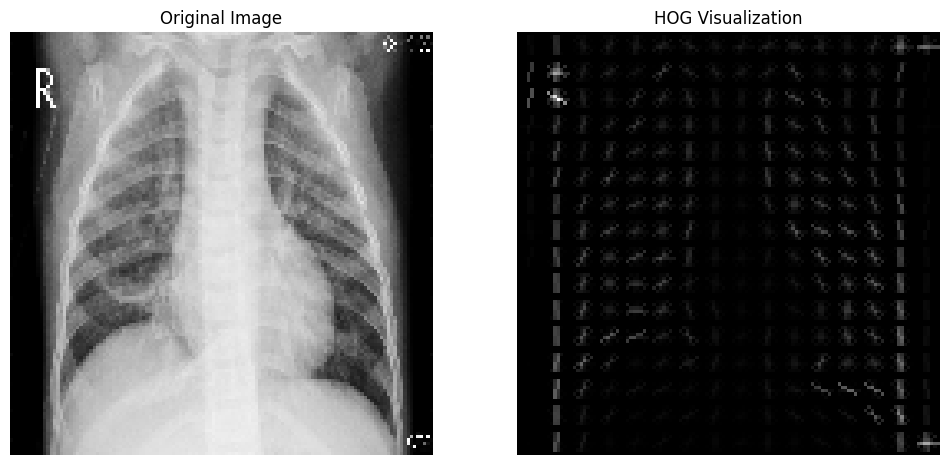

In [15]:
# Extract the flattened image and reshape it
img_flatten = X_train[0]
img = img_flatten.reshape(128, 128)  # Reshape to 2D

# Compute HOG features and HOG image for visualization
hog_features, hog_image = hog(img, pixels_per_cell=(8, 8),
                                cells_per_block=(2, 2), orientations=9, visualize=True) # cells_per_block=(2, 2), visualize=True, block_norm="L1", transform_sqrt=False

# Rescale HOG image for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(img, cmap=plt.cm.gray)
ax1.set_title('Original Image')

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('HOG Visualization')
plt.show()


In [16]:
def extract_hog_features(X_image):
    hog_features = []
    for img_flatten in tqdm(X_image, desc="Extracting HOG Features"):
        img = img_flatten.reshape(128, 128)
        hog_feat = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), orientations=9, visualize=False)
        hog_features.append(hog_feat)
    return pd.DataFrame(hog_features)

X_train_hog = extract_hog_features(X_train)
X_train_augmented_hog = extract_hog_features(X_train_augmented)
X_train_downsampled_hog = extract_hog_features(X_train_downsampled)

X_val_hog = extract_hog_features(X_val)
X_test_hog = extract_hog_features(X_test)


Extracting HOG Features:   0%|          | 0/4694 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/6974 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/2414 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/538 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/624 [00:00<?, ?it/s]

### Intensity Features

Pixel intensity histograms capture the distribution of pixel values within an image. This method counts the occurrences of each pixel intensity, providing a simple yet informative representation of the image’s overall brightness and contrast characteristics.

In [17]:
def extract_intensities(X_image):
    num_intensities = 256
    features = []
    for image in tqdm(X_image, desc="Extracting HOG Features"):
        # Count occurrences of each pixel intensity
        counts, _ = np.histogram(image, bins=np.arange(num_intensities + 1), range=(0, num_intensities))
        features.append(counts)
    
    return pd.DataFrame(features)

X_train_intensities = extract_intensities(X_train)
X_train_augmented_intensities = extract_intensities(X_train_augmented)
X_train_downsampled_intensities = extract_intensities(X_train_downsampled)

X_val_intensities = extract_intensities(X_val)
X_test_intensities = extract_intensities(X_test)

Extracting HOG Features:   0%|          | 0/4694 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/6974 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/2414 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/538 [00:00<?, ?it/s]

Extracting HOG Features:   0%|          | 0/624 [00:00<?, ?it/s]

# Train Evaluate Classical ML Models

In [18]:
# Plots multiple confusion matrices in a grid layout to visually 
# compare the performance of different models.
def plot_all_cfs(cf_info, n_rows, n_cols, save_path=None):
    total_plots = n_rows * n_cols
    num_matrices = len(cf_info)

    if num_matrices > total_plots:
        raise ValueError(f"Number of confusion matrices ({num_matrices}) exceeds grid capacity ({total_plots}).")
    
    plt.figure(figsize=(n_cols * 8, n_rows * 6))  # Adjust the figure size based on the grid size
    
    for idx, (cm, title) in enumerate(cf_info, start=1):
        plt.subplot(n_rows, n_cols, idx)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
        plt.title(title)
        plt.xlabel('Predicted')
        plt.ylabel('True')
    
    plt.tight_layout(pad=3.0)
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()

# rains an SVM classifier and evaluates its performance on the test dataset, 
# returning a confusion matrix and evaluation metrics.
def train_and_evaluate_svm(X_train, X_val, X_test, y_train, y_val, y_test, features_name, balanced_msg, le, average):
    svm_clf = SVC(kernel='linear')
    start_time = time.time()
    svm_clf.fit(X_train, y_train)
    total_time = time.time() - start_time

    y_test_pred = svm_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
                                   
    print(f"SVM Classification Report for {features_name} on Test Set (using {balanced_msg} training dataset):")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    cf = confusion_matrix(y_test, y_test_pred)
    cf_title = f'SVM with {features_name} using {balanced_msg} training dataset'
    
    train_eval_info = {
        'model': 'SVM',
        'features': features_name,
        'dataset': balanced_msg,
        'f1_score': f1_score(y_test, y_test_pred, average=average),
        'precision': precision_score(y_test, y_test_pred, average=average),
        'recall': recall_score(y_test, y_test_pred, average=average),
        'test_accuracy': test_accuracy,
        'train_time': total_time
    }

    return cf, cf_title, train_eval_info

# Trains a Random Forest classifier and evaluates its performance on the test dataset, 
# returning a confusion matrix and evaluation metrics.
def train_and_evaluate_rf(X_train, X_val, X_test, y_train, y_val, y_test, features_name, balanced_msg, le, average):
    rf_clf = RandomForestClassifier(n_estimators=100)
    start_time = time.time()
    rf_clf.fit(X_train, y_train)
    total_time = time.time() - start_time 

    y_test_pred = rf_clf.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"Random Forest Classification Report for {features_name} on Test Set (using {balanced_msg} training dataset):")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    cf = confusion_matrix(y_test, y_test_pred)
    cf_title = f'Random Forest with {features_name} using {balanced_msg} training dataset'

    train_eval_info = {
        'model': 'RF',
        'features': features_name,
        'dataset': balanced_msg,
        'f1_score': f1_score(y_test, y_test_pred, average=average),
        'precision': precision_score(y_test, y_test_pred, average=average),
        'recall': recall_score(y_test, y_test_pred, average=average),
        'test_accuracy': test_accuracy,
        'train_time': total_time
    }
    
    return cf, cf_title, train_eval_info

# Trains and evaluates both SVM and Random Forest models, 
# returning their confusion matrices and titles.
def train_and_evaluate_models(X_train, X_val, X_test, y_train, y_val, y_test, features_name, balanced_msg, le, average='macro'):
    svm_cf, svm_cf_tile, svm_train_eval_info = train_and_evaluate_svm(X_train, X_val, X_test, y_train, y_val, y_test, features_name, balanced_msg, le, average)
    rf_cf, rf_cf_tile, rf_train_eval_info = train_and_evaluate_rf(X_train, X_val, X_test, y_train, y_val, y_test, features_name, balanced_msg, le, average)
    return (svm_cf, svm_cf_tile), (rf_cf, rf_cf_tile), svm_train_eval_info, rf_train_eval_info

# Visualizes the comparison of model performance metrics 
# (F1-score, precision, recall, accuracy) using bar plots
def plot_model_comparisons(metrics_list):
    df = pd.DataFrame(metrics_list)
    plt.figure(figsize=(18, 12))  
    
    # Create a combined hue category for model and dataset
    df['model_dataset'] = df['model'] + '-' + df['dataset']
    
    n_rows, n_cols = 2, 2
    
    # Plot F1 scores
    plt.subplot(n_rows, n_cols, 1)
    sns.barplot(data=df, x='features', y='f1_score', hue='model_dataset', dodge=True)
    plt.title('F1 Score Comparison')
    plt.xlabel('Features')
    plt.ylabel('F1 Score')
    plt.legend(title='Model-Dataset')
    plt.xticks(rotation=45)
    
    # Plot Precision
    plt.subplot(n_rows, n_cols, 2)
    sns.barplot(data=df, x='features', y='precision', hue='model_dataset', dodge=True)
    plt.title('Precision Comparison')
    plt.xlabel('Features')
    plt.ylabel('Precision')
    plt.legend(title='Model-Dataset')
    plt.xticks(rotation=45)

    # Plot Recall
    plt.subplot(n_rows, n_cols, 3)
    sns.barplot(data=df, x='features', y='recall', hue='model_dataset', dodge=True)
    plt.title('Recall Comparison')
    plt.xlabel('Features')
    plt.ylabel('Recall')
    plt.legend(title='Model-Dataset')
    plt.xticks(rotation=45)

    # Plot Test Accuracy
    plt.subplot(n_rows, n_cols, 4)
    sns.barplot(data=df, x='features', y='test_accuracy', hue='model_dataset', dodge=True)
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Features')
    plt.ylabel('Test Accuracy')
    plt.legend(title='Model-Dataset')
    plt.xticks(rotation=45)
    
    plt.tight_layout(pad=3.0)  # Add padding to prevent overlap
    plt.show()

In [19]:
clasic_ml_metrics_info = []
imbalanced_cf_info = []
augmented_cf_info = []
downsampled_cf_info = []

svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_and_evaluate_models(X_train_hog, X_val_hog, X_test_hog, y_train, y_val, y_test, "HOG Features", "imbalanced", le, 'weighted')
imbalanced_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])
svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_and_evaluate_models(X_train_intensities, X_val_intensities, X_test_intensities, y_train, y_val, y_test, "Intensity Features", "imbalanced", le, 'weighted')
imbalanced_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])

svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_and_evaluate_models(X_train_augmented_hog, X_val_hog, X_test_hog, y_train_augmented, y_val, y_test, "HOG Features", "augmented", le)
augmented_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])
svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_and_evaluate_models(X_train_augmented_intensities, X_val_intensities, X_test_intensities, y_train_augmented, y_val, y_test, "Intensity Features", "augmented", le)
augmented_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])

svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_and_evaluate_models(X_train_downsampled_hog, X_val_hog, X_test_hog, y_train_downsampled, y_val, y_test, "HOG Features", "downsampled", le)
downsampled_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])
svm_cf_info, rf_cf_info, svm_metrics_info, rf_metrics_info = train_eval_info = train_and_evaluate_models(X_train_downsampled_intensities, X_val_intensities, X_test_intensities, y_train_downsampled, y_val, y_test, "Intensity Features", "downsampled", le)
downsampled_cf_info.extend([svm_cf_info, rf_cf_info])
clasic_ml_metrics_info.extend([svm_metrics_info, rf_metrics_info])

SVM Classification Report for HOG Features on Test Set (using imbalanced training dataset):
              precision    recall  f1-score   support

      NORMAL       0.98      0.35      0.52       234
   PNEUMONIA       0.72      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.67      0.68       624
weighted avg       0.82      0.75      0.71       624

Random Forest Classification Report for HOG Features on Test Set (using imbalanced training dataset):
              precision    recall  f1-score   support

      NORMAL       0.92      0.26      0.40       234
   PNEUMONIA       0.69      0.99      0.81       390

    accuracy                           0.71       624
   macro avg       0.81      0.62      0.61       624
weighted avg       0.78      0.71      0.66       624

SVM Classification Report for Intensity Features on Test Set (using imbalanced training dataset):
              precision    recall  f1-score   support


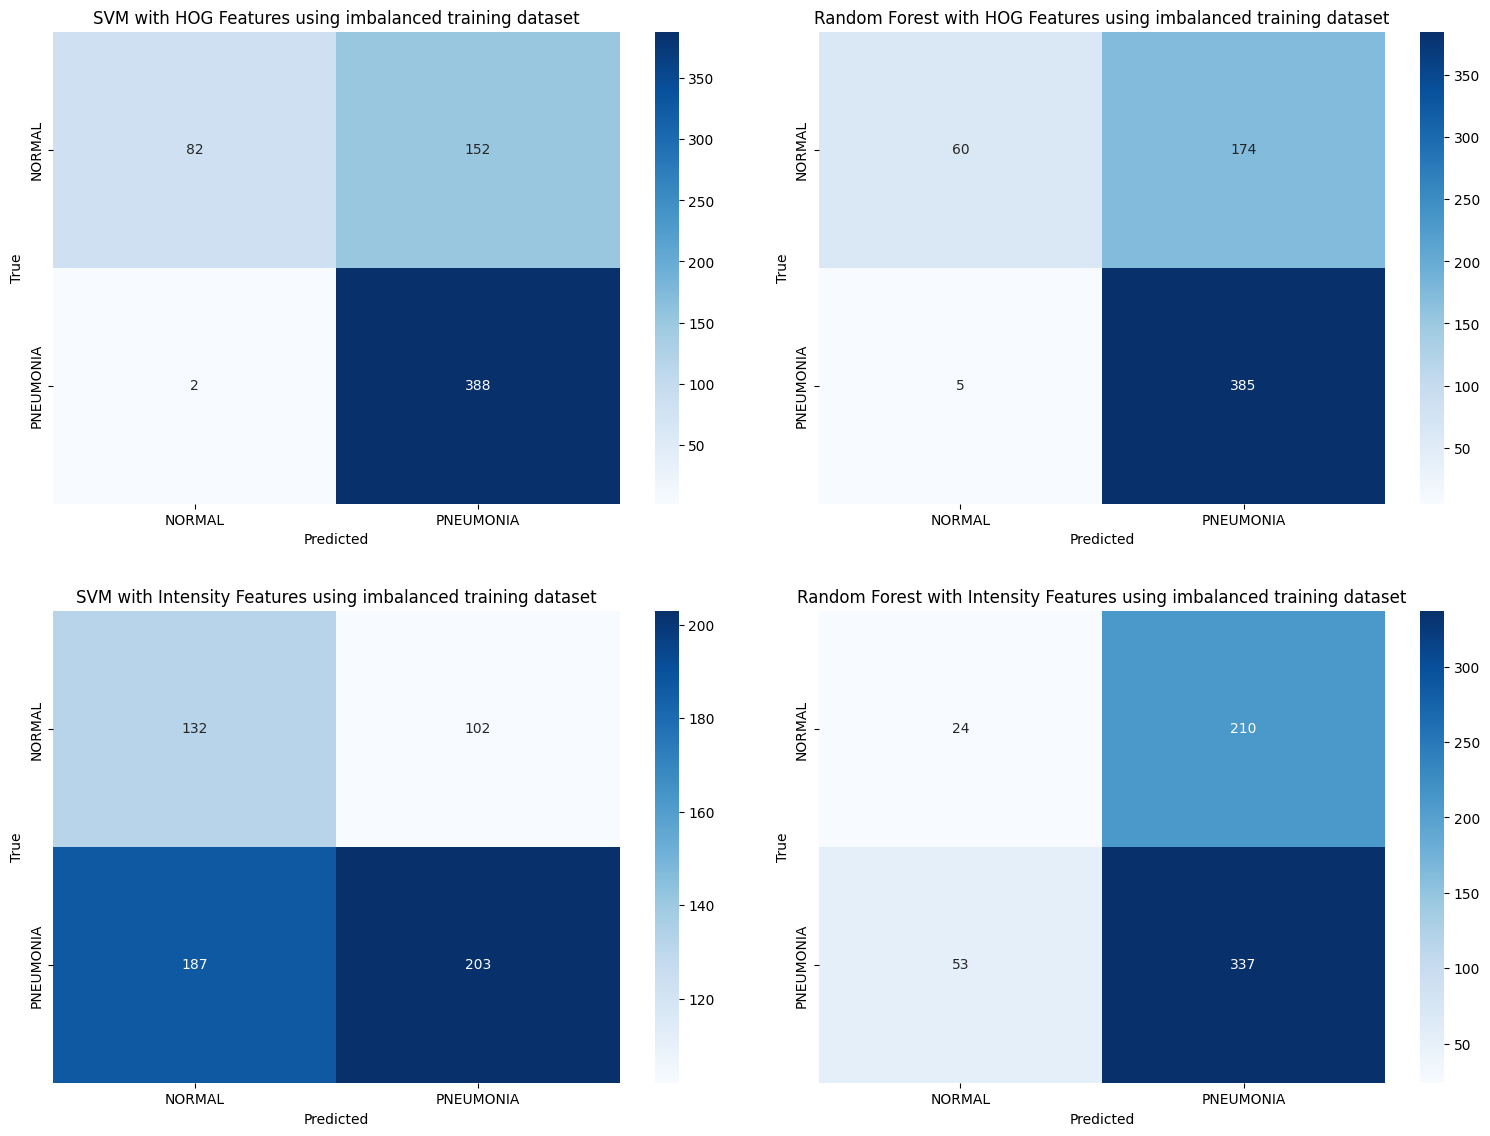

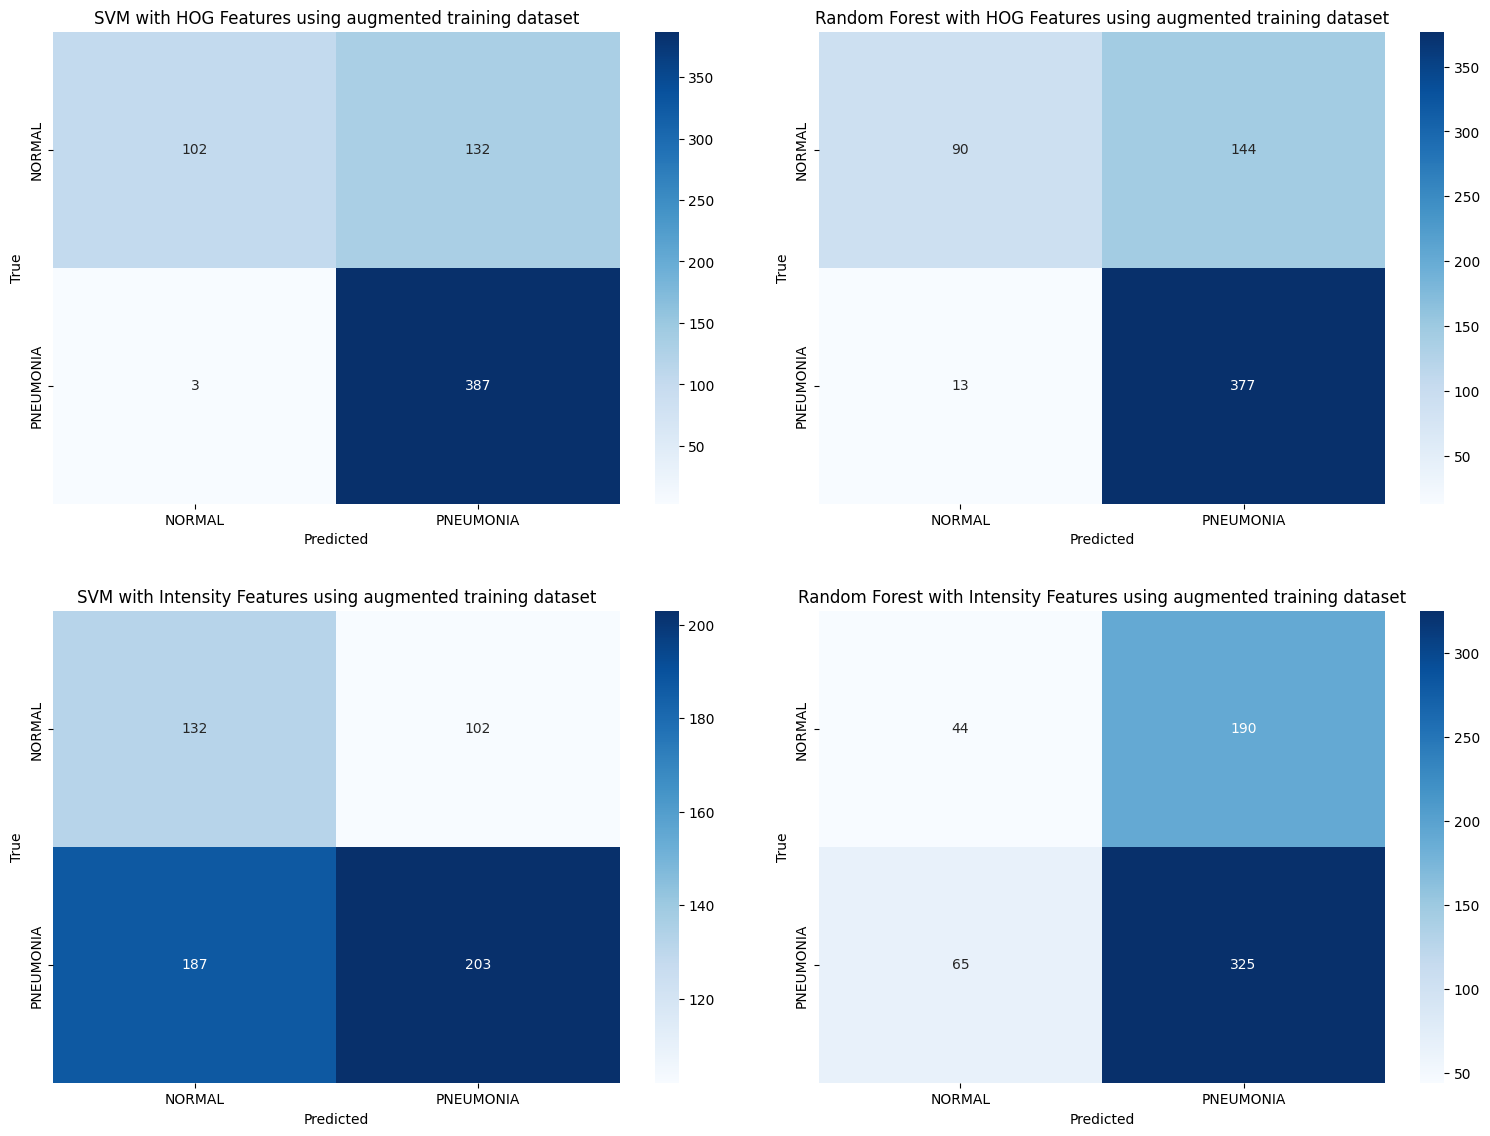

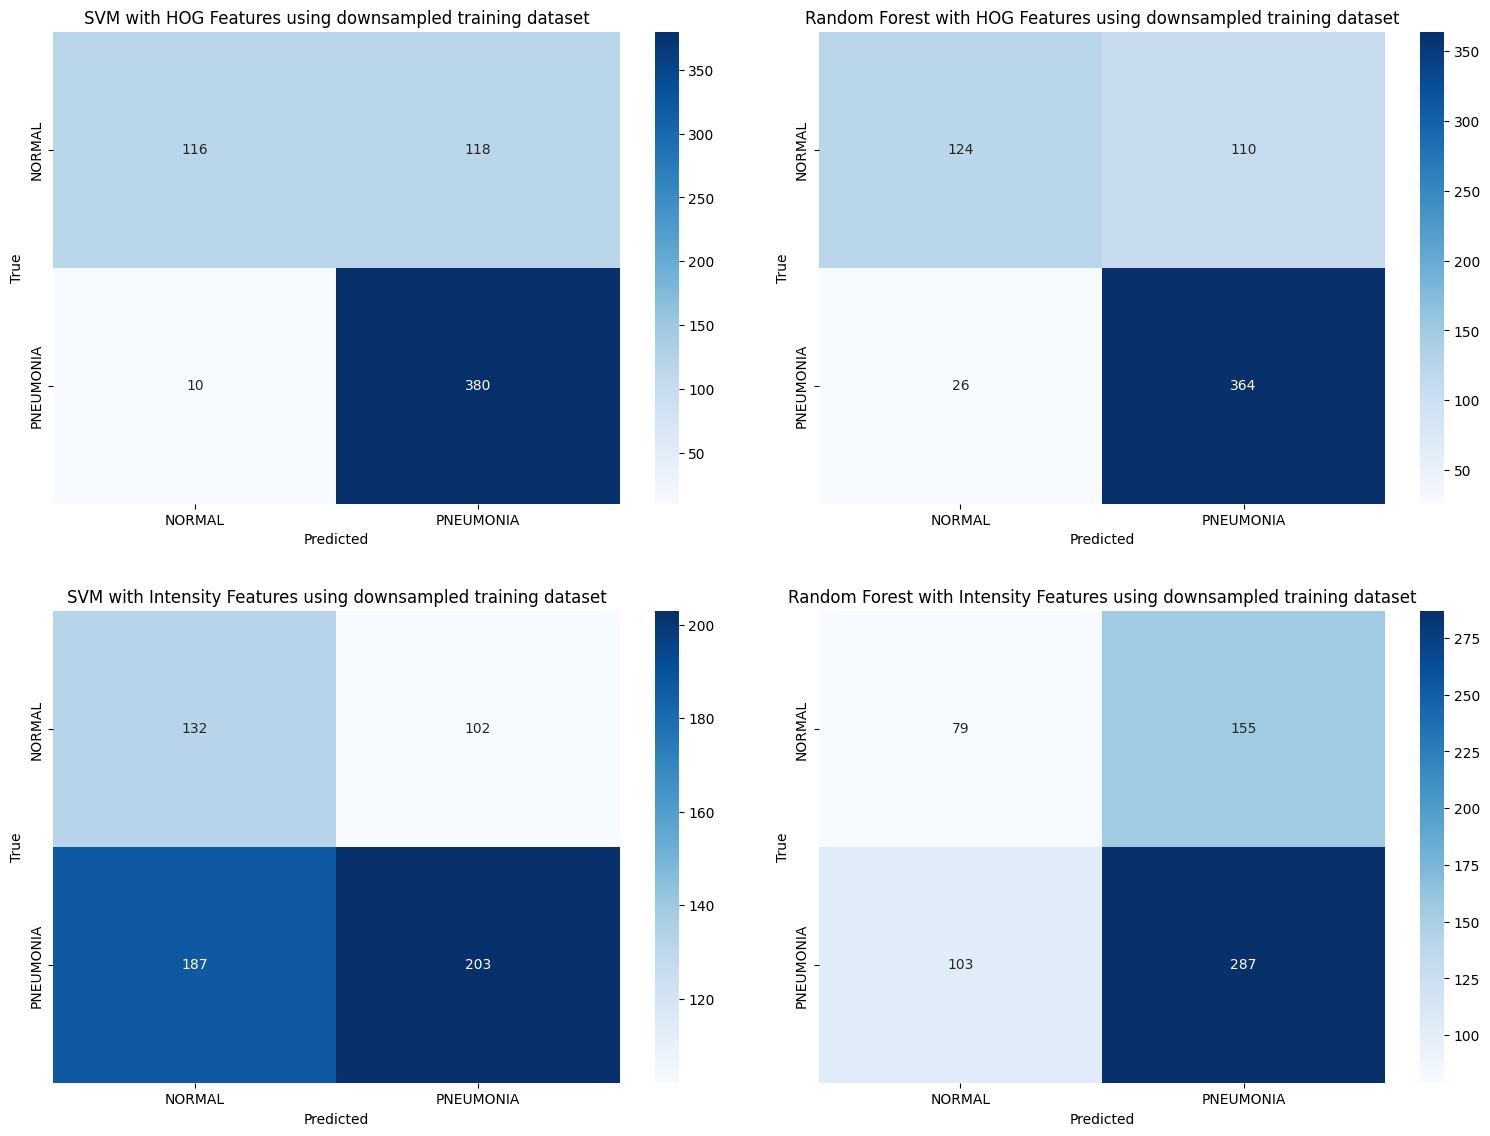

In [20]:
plot_all_cfs(imbalanced_cf_info, 2, 2)
plot_all_cfs(augmented_cf_info, 2, 2)
plot_all_cfs(downsampled_cf_info, 2, 2)

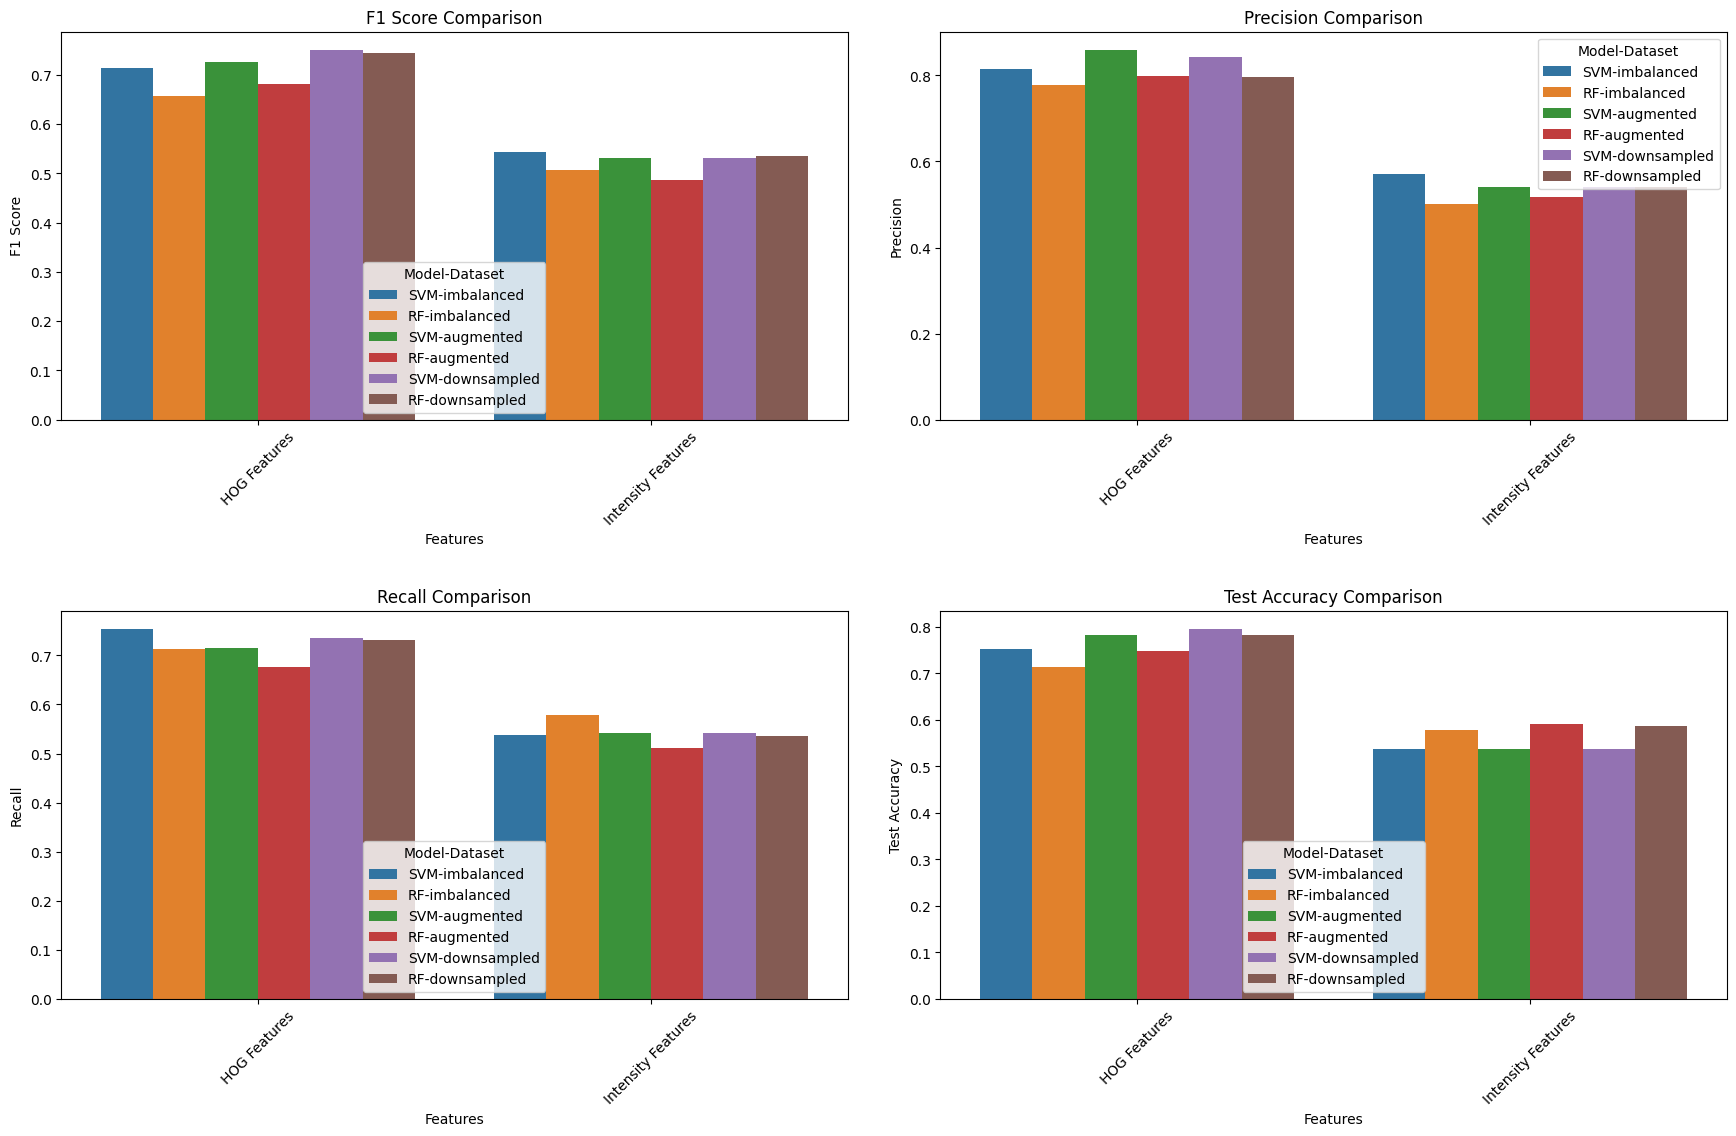

In [21]:
plot_model_comparisons(clasic_ml_metrics_info)

**HOG Features**:
* **SVM with Imbalanced Dataset:**
The SVM model showed relatively high precision and recall for pneumonia, but struggled with normal cases, as indicated by a low recall of 0.35 for normal, leading to a moderate F1 score.

* **RF with Imbalanced Dataset:**
The Random Forest model had a similar pattern to the SVM, with decent precision for pneumonia but poor recall for normal cases.

* **SVM with Augmented Dataset:**
Augmentation improved SVM performance, enhancing precision and F1 score slightly compared to the imbalanced dataset.

* **RF with Augmented Dataset:**
Similar to SVM, Random Forest benefited from augmentation but with more modest improvements.

* **SVM with Downsampled Dataset:**
Downsampling led to the best performance for SVM, with improved precision, recall, and F1 score.

* **RF with Downsampled Dataset:**
Random Forest also performed well with downsampling, showing balanced metrics and improved overall performance.

**Intensity Features:**
* **SVM with Imbalanced Dataset:**
The SVM model showed poor performance with intensity features, with low precision and recall leading to a low F1 score.

* **RF with Imbalanced Dataset:**
Random Forest had similar issues as SVM, with low precision for normal cases and overall poor performance.

* **SVM with Augmented Dataset:**
Augmentation did not significantly improve performance for SVM with intensity features.

* **RF with Augmented Dataset:**
Random Forest showed slight improvement in precision but still struggled overall.

* **SVM with Downsampled Dataset:**
Downsampling did not significantly impact SVM performance, which remained low.

* **RF with Downsampled Dataset:**
Random Forest performance remained low, showing minimal improvement with downsampling.

In [81]:
clasic_ml_metrics_info_df = pd.DataFrame(clasic_ml_metrics_info)
display(clasic_ml_metrics_info_df)

,model,features,dataset,f1_score,precision,recall,test_accuracy,train_time
0,SVM,HOG Features,imbalanced,0.714902,0.815146,0.753205,0.753205,10.091388
1,RF,HOG Features,imbalanced,0.657614,0.776610,0.713141,0.713141,24.156561
2,SVM,Intensity Features,imbalanced,0.544131,0.571156,0.536859,0.536859,0.220459
3,RF,Intensity Features,imbalanced,0.507451,0.501938,0.578526,0.578526,0.128327
4,SVM,HOG Features,augmented,0.726628,0.858547,0.714103,0.783654,20.497060
5,RF,HOG Features,augmented,0.680893,0.798697,0.675641,0.748397,37.534164
6,SVM,Intensity Features,augmented,0.530784,0.539683,0.542308,0.536859,1.415377
7,RF,Intensity Features,augmented,0.487396,0.517369,0.510684,0.591346,0.178602
8,SVM,HOG Features,downsampled,0.750150,0.841844,0.735043,0.794872,3.536190
9,RF,HOG Features,downsampled,0.744213,0.797300,0.731624,0.782051,9.292893


# Train Evaluate NN Models

In this section, we will explore and evaluate three different neural network models:

* Basic Neural Network (NN):
A straightforward feedforward network with dense layers, aimed at establishing a baseline for performance comparison.

* Convolutional Neural Network (CNN):
A more complex architecture that leverages convolutional layers to capture spatial features from images.

* Transfer Learning Model:
A sophisticated approach utilizing MobileNetV2 pretrained on the ImageNet dataset. This model is fine-tuned for our specific classification task, benefiting from the pretrained network's powerful feature extraction capabilities.

**MobileNetV2** is a state-of-the-art, lightweight convolutional neural network architecture designed for efficient performance on mobile and embedded devices. Its core features include:
* Inverted Residuals: Efficiently capture spatial features with fewer computations.
* Linear Bottlenecks: Reduce the number of parameters while maintaining representational power.
* Depthwise Separable Convolutions: Minimize the computation by factorizing standard convolutions into depthwise and pointwise convolutions.

In [23]:
# plot train accuracy vs val accuracy
# and train loss vs val loss
def plot_training_history(history, model_name, balanced_msg):
    plt.figure(figsize=(14, 6))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Train & Val Accuracy - {model_name} using {balanced_msg} training dataset')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Train & Val Loss - {model_name} using {balanced_msg} training dataset')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Visualizes the comparison of model performance metrics 
# (F1-score, precision, recall, accuracy) using bar plots
def plot_nn_model_comparisons(metrics_list):
    df = pd.DataFrame(metrics_list)
    plt.figure(figsize=(18, 12))  # Adjust the figsize for better visualization

    # Create a combined category for model and dataset
    df['model_dataset'] = df['model'] + '-' + df['dataset']
    
    # Define the number of rows and columns for the subplots
    n_rows, n_cols = 2, 2

    # Plot F1 scores
    plt.subplot(n_rows, n_cols, 1)
    sns.barplot(data=df, x='model_dataset', y='f1_score')
    plt.title('F1 Score Comparison')
    plt.xlabel('Model-Dataset Combination')
    plt.ylabel('F1 Score')
    plt.xticks(rotation=45)
    
    # Plot Precision
    plt.subplot(n_rows, n_cols, 2)
    sns.barplot(data=df, x='model_dataset', y='precision')
    plt.title('Precision Comparison')
    plt.xlabel('Model-Dataset Combination')
    plt.ylabel('Precision')
    plt.xticks(rotation=45)

    # Plot Recall
    plt.subplot(n_rows, n_cols, 3)
    sns.barplot(data=df, x='model_dataset', y='recall')
    plt.title('Recall Comparison')
    plt.xlabel('Model-Dataset Combination')
    plt.ylabel('Recall')
    plt.xticks(rotation=45)

    # Plot Test Accuracy
    plt.subplot(n_rows, n_cols, 4)
    sns.barplot(data=df, x='model_dataset', y='test_accuracy')
    plt.title('Test Accuracy Comparison')
    plt.xlabel('Model-Dataset Combination')
    plt.ylabel('Test Accuracy')
    plt.xticks(rotation=45)
    
    plt.tight_layout(pad=3.0)  # Add padding to prevent overlap
    plt.show()

In [24]:
def build_nn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [25]:
def build_cnn(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

The architecture of the transfer learning model includes:

**Base Model**:
* MobileNetV2 with pretrained ImageNet weights.
* Top layers removed (include_top=False), focusing on feature extraction.
* The base model is frozen (trainable=False) to prevent updating its weights during training.
  
**Custom Layers:**
* GlobalAveragePooling2D: Reduces the spatial dimensions to a single vector.
* Dense layer with 128 neurons and ReLU activation.
* Dropout layer with a 30% drop rate to prevent overfitting.
* Output Layer: A single neuron with sigmoid activation for binary classification.

In [63]:
def build_transfer_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model

    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In the train evaluation process we train and evaluate a NN model with the following steps:

* Early Stopping and Learning Rate Reduction: \
EarlyStopping: Monitors validation loss, stops training if no improvement is seen after 3 epochs.\
ReduceLROnPlateau: Reduces learning rate when validation loss plateaus, with a factor of 0.2.

* Model Training:\
Uses the fit method to train the model on the training data (X_train, y_train).\
Validation data (X_val, y_val) helps to monitor the model’s performance during training.\
Epochs: Set to 50 with a batch size of 32.

* Evaluation:\
Evaluates the model on the test set (X_test, y_test) to obtain test loss and accuracy.\
Predicts classes on the test set and converts probabilities to binary predictions (>= 0.5).

* Metrics Calculation:\
Computes F1 score, precision, and recall for the test predictions

In [85]:
def train_and_evaluate_dl(model, X_train, X_val, X_test, y_train, y_val, y_test, model_name, balanced_msg, label_encoder, epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, min_delta=1e-7, mode='min')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_delta = 1e-7,)

    start_time = time.time()
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    end_time = time.time() - start_time

    evaluation_results = model.evaluate(X_test, y_test, verbose=0)
    test_loss = evaluation_results[0]
    test_accuracy = evaluation_results[1]

    y_test_pred = model.predict(X_test)
    y_test_pred_classes = (y_test_pred >= 0.5).astype(int).flatten()
    
    test_f1_score = f1_score(y_test, y_test_pred_classes, zero_division=0)
    test_precision = precision_score(y_test, y_test_pred_classes, zero_division=0)
    test_recall = recall_score(y_test, y_test_pred_classes, zero_division=0)

    print(f"\nClassification Report for {model_name} (using {balanced_msg} training dataset):")
    print(classification_report(y_test, y_test_pred_classes))
    
    cf = confusion_matrix(y_test, y_test_pred_classes)
    title = f'Confusion Matrix for {model_name} using {balanced_msg} training dataset'
    
    info = {
        'model': model_name,
        'features': 'N/A',
        'dataset': balanced_msg,
        'f1_score': test_f1_score,
        'precision': test_precision,
        'recall': test_recall,
        'test_accuracy': test_accuracy,
        'train_time': end_time
    }
    
    return info, history, (cf, title)


Reshape the features dimensions to be acceptable by each model

In [38]:
def to_rgb(images):
    if images.shape[-1] == 1:  # If single channel, replicate to 3 channels
        return np.repeat(images, 3, axis=-1)
    return images

X_train_cnn = X_train.reshape(-1, 128, 128, 1)
X_train_augmented_cnn = X_train_augmented.reshape(-1, 128, 128, 1)
X_train_downsampled_cnn = X_train_downsampled.reshape(-1, 128, 128, 1)

X_val_cnn = X_val.reshape(-1, 128, 128, 1)
X_test_cnn = X_test.reshape(-1, 128, 128, 1)

X_train_rgb = to_rgb(X_train_cnn)
X_train_augmented_rgb = to_rgb(X_train_augmented_cnn)
X_train_downsampled_rgb = to_rgb(X_train_downsampled_cnn)

X_val_rgb = to_rgb(X_val_cnn)
X_test_rgb = to_rgb(X_test_cnn)

In [86]:
nn_metrics_info = []
imbalanced_cf_info = []
augmented_cf_info = []
downsampled_cf_info = []

## Simple NN Evaluation

Model: "sequential_37"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_25 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_86 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_87 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,097,409 (8.00 MB)

 Trainable params: 2,097,409 (8.00 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7451 - loss: 2.1654 - val_accuracy: 0.8643 - val_loss: 0.3657 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9210 - loss: 0.1976 - val_accuracy: 0.9089 - val_loss: 0.2500 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9133 - loss: 0.2313 - val_accuracy: 0.9535 - val_loss: 0.1257 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9454 - loss: 0.1432 - val_accuracy: 0.9554 - val_loss: 0.1150 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9432 - loss: 0.1534 - val_accuracy: 0.9349 - val_loss: 0.1894 - learning_rate: 0.0010
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9551 - loss: 0.1155 - val_accuracy: 0.8383 - val_loss: 0.5736 - learning_rate: 0.0010
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9181 - loss: 0.24

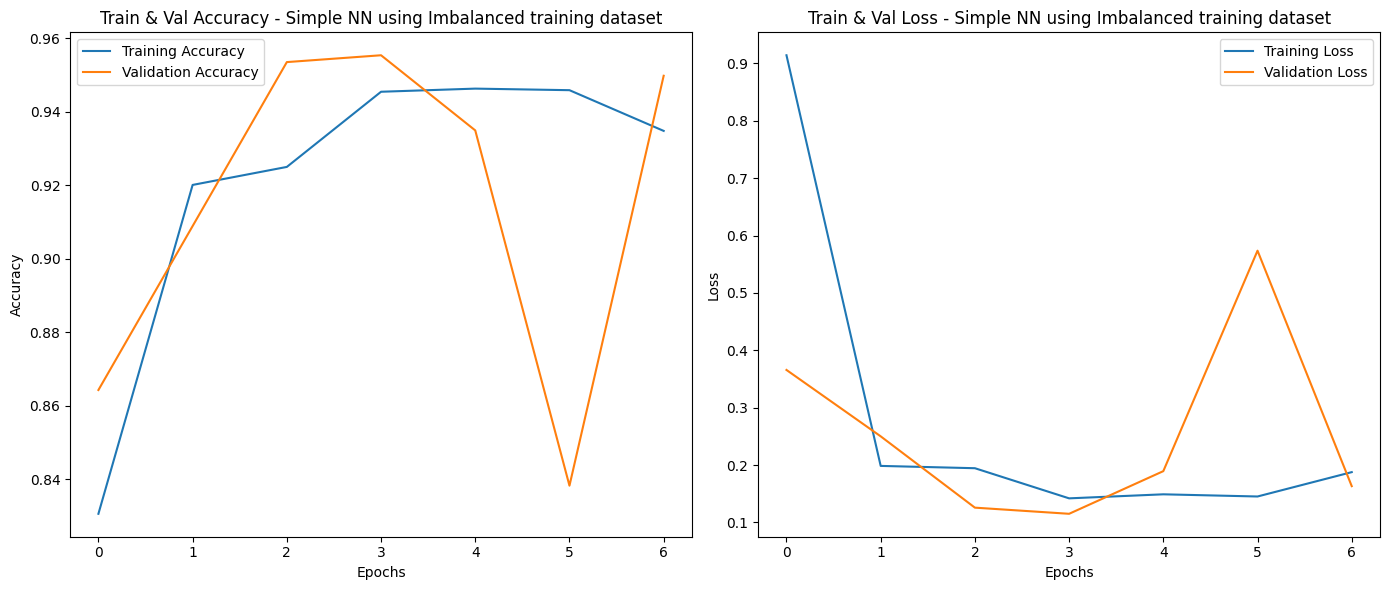

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6495 - loss: 1.1337 - val_accuracy: 0.6766 - val_loss: 0.5933 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8353 - loss: 0.3684 - val_accuracy: 0.9145 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8813 - loss: 0.2829 - val_accuracy: 0.9405 - val_loss: 0.1907 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9138 - loss: 0.2137 - val_accuracy: 0.9071 - val_loss: 0.2165 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9229 - loss: 0.1960 - val_accuracy: 0.9517 - val_loss: 0.1383 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9258 - loss: 0.1888 - val_accuracy: 0.9554 - val_loss: 0.1458 - learning_rate: 0.0010
Epoch 7/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9233 - loss: 0.1939 - 

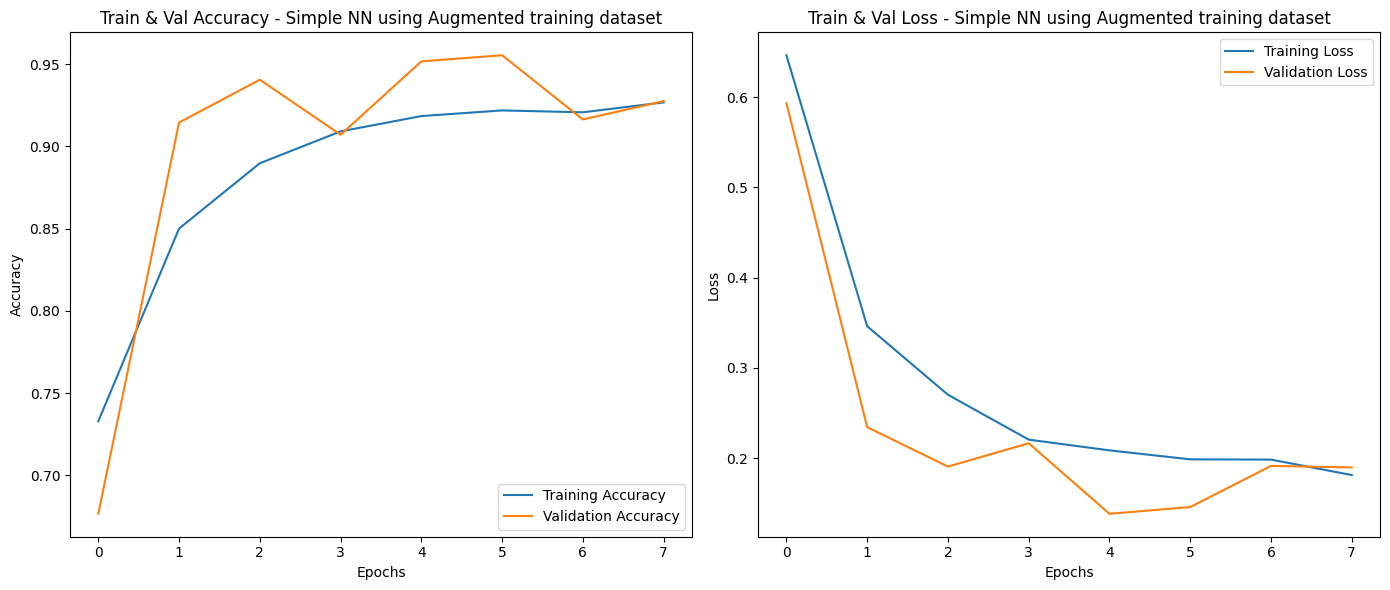

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6787 - loss: 1.7410 - val_accuracy: 0.9219 - val_loss: 0.2265 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9013 - loss: 0.2439 - val_accuracy: 0.8959 - val_loss: 0.2480 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9158 - loss: 0.2039 - val_accuracy: 0.8866 - val_loss: 0.2760 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9452 - loss: 0.1492 - val_accuracy: 0.8959 - val_loss: 0.2638 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 

Classification Report for Simple NN (using Downsampled training dataset):
              precision    recall  f1-score   support

           0       0.80      0.74      0.77       234
           1       0.85      0.89      0.87       390

    accuracy                           0.83       624
   macro avg       0.83      0.82      0.82       624
weighted avg 

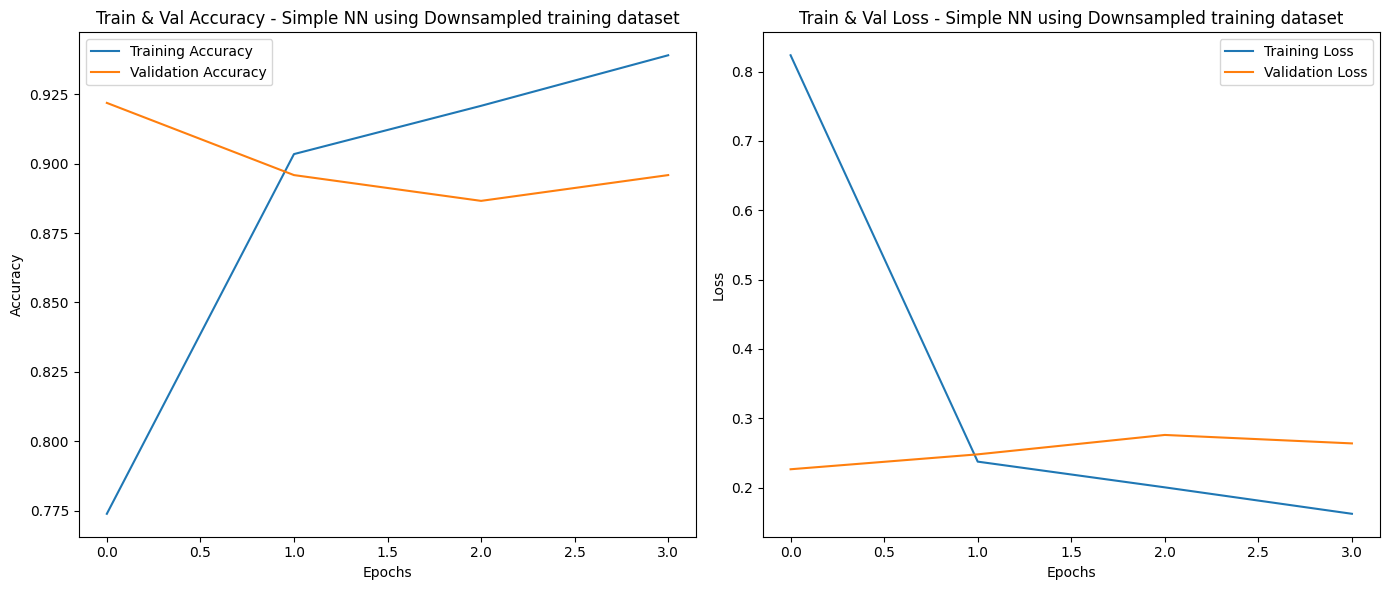

In [87]:
epochs = 50

# Simple NN
input_shape = X_train.shape[1:]

nn_model = build_nn(input_shape)
print(nn_model.summary())
nn_info, history, cf_info = train_and_evaluate_dl(nn_model, X_train, X_val, X_test, y_train, y_val, y_test, "Simple NN", "Imbalanced", le, epochs)
nn_metrics_info.append(nn_info)
imbalanced_cf_info.append(cf_info)
plot_training_history(history, "Simple NN", "Imbalanced")

nn_model = build_nn(input_shape)
nn_info, history, cf_info = train_and_evaluate_dl(nn_model, X_train_augmented, X_val, X_test, y_train_augmented, y_val, y_test, "Simple NN", "Augmented", le, epochs)
nn_metrics_info.append(nn_info)
augmented_cf_info.append(cf_info)
plot_training_history(history, "Simple NN", "Augmented")

nn_model = build_nn(input_shape)
nn_info, history, cf_info = train_and_evaluate_dl(nn_model, X_train_downsampled, X_val, X_test, y_train_downsampled, y_val, y_test, "Simple NN", "Downsampled", le, epochs)
nn_metrics_info.append(nn_info)
downsampled_cf_info.append(cf_info)
plot_training_history(history, "Simple NN", "Downsampled")

## CNN Evaluation

Model: "sequential_40"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_60 (Conv2D)              │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_61 (Conv2D)              │ (None, 61, 61, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_64 (Conv2D)              │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_64 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_28 (Flatten)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,457 (451.00 KB)

 Trainable params: 115,457 (451.00 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.7671 - loss: 0.5379 - val_accuracy: 0.9219 - val_loss: 0.1749 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9285 - loss: 0.1853 - val_accuracy: 0.9572 - val_loss: 0.1082 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9616 - loss: 0.0998 - val_accuracy: 0.9387 - val_loss: 0.1399 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.9613 - loss: 0.0925 - val_accuracy: 0.9498 - val_loss: 0.1253 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9769 - loss: 0.0649 - val_accuracy: 0.9517 - val_loss: 0.1417 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report for CNN (using Imbalanced training dataset):
              precision    recall  f1-score   support

           0       1.00      0.26      0.42       234
           1  

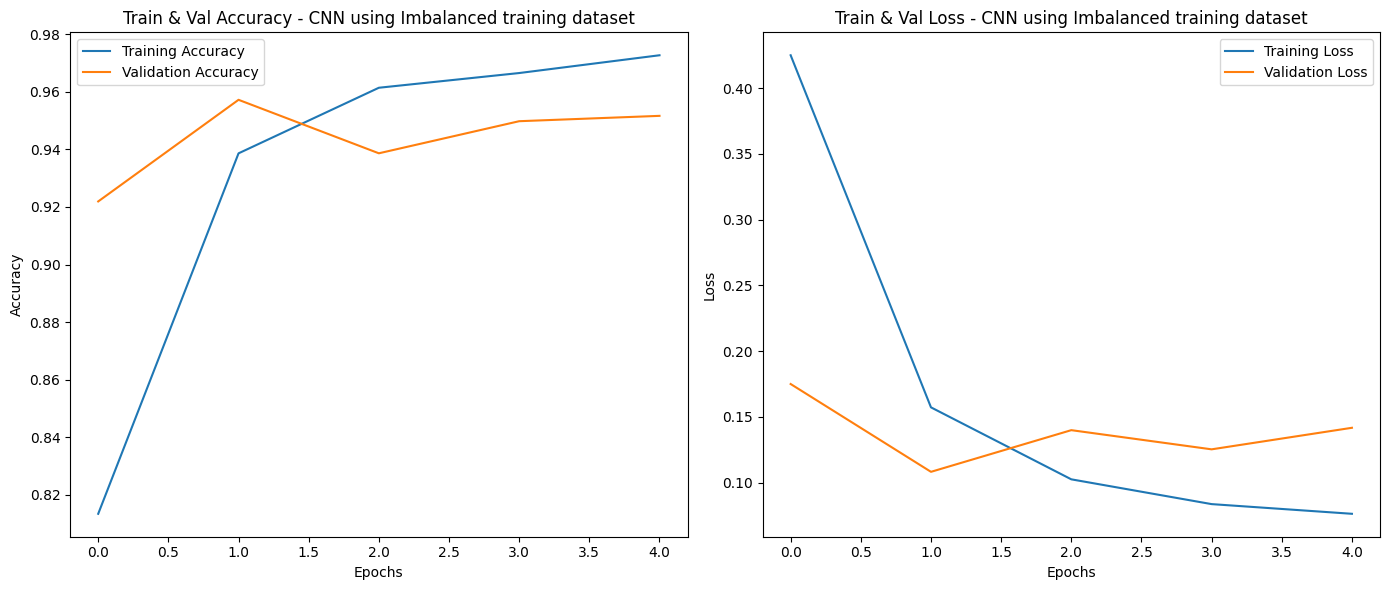

Epoch 1/3
218/218 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - accuracy: 0.6394 - loss: 0.6022 - val_accuracy: 0.8662 - val_loss: 0.3234 - learning_rate: 0.0010
Epoch 2/3
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9216 - loss: 0.2064 - val_accuracy: 0.9480 - val_loss: 0.1286 - learning_rate: 0.0010
Epoch 3/3
218/218 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.9545 - loss: 0.1229 - val_accuracy: 0.9498 - val_loss: 0.1151 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report for CNN (using Augmented training dataset):
              precision    recall  f1-score   support

           0       0.96      0.38      0.54       234
           1       0.73      0.99      0.84       390

    accuracy                           0.76       624
   macro avg       0.84      0.68      0.69       624
weighted avg       0.81      0.76      0.73       624



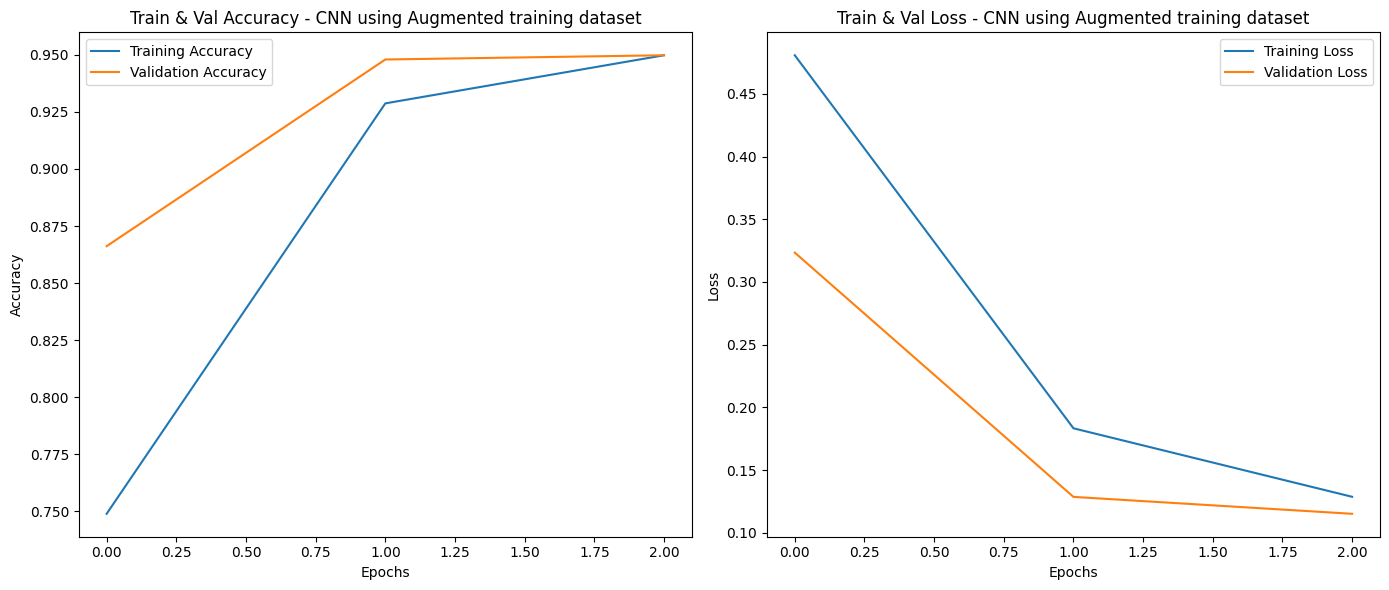

Epoch 1/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6220 - loss: 0.6515 - val_accuracy: 0.8773 - val_loss: 0.2969 - learning_rate: 0.0010
Epoch 2/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.8938 - loss: 0.2725 - val_accuracy: 0.9498 - val_loss: 0.1505 - learning_rate: 0.0010
Epoch 3/3
76/76 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.9433 - loss: 0.1477 - val_accuracy: 0.9480 - val_loss: 0.1308 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

Classification Report for CNN (using Downsampled training dataset):
              precision    recall  f1-score   support

           0       0.90      0.68      0.78       234
           1       0.83      0.95      0.89       390

    accuracy                           0.85       624
   macro avg       0.87      0.82      0.83       624
weighted avg       0.86      0.85      0.85       624



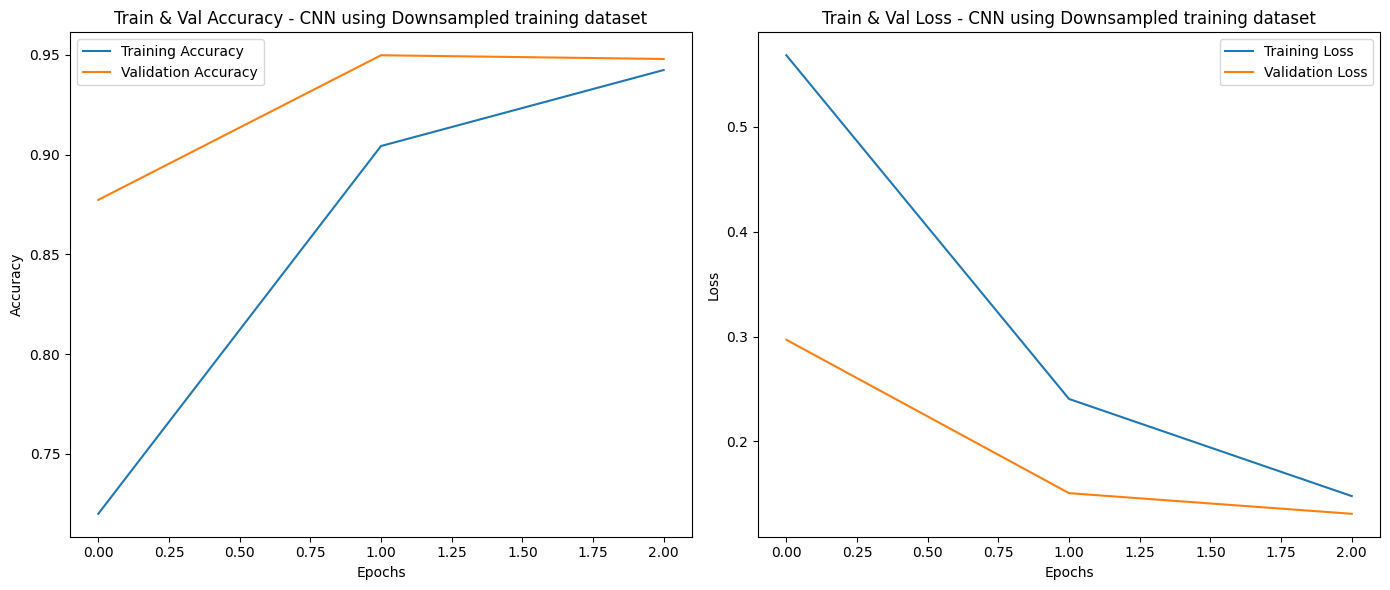

In [88]:
# CNN
input_shape = (128, 128, 1)  
epochs = 50

cnn_model = build_cnn(input_shape)
print(cnn_model.summary())
cnn_info, history, cf_info = train_and_evaluate_dl(cnn_model, X_train_cnn, X_val_cnn, X_test_cnn, y_train, y_val, y_test, "CNN", "Imbalanced", le, epochs)
nn_metrics_info.append(cnn_info)
imbalanced_cf_info.append(cf_info)
plot_training_history(history, "CNN", "Imbalanced")

cnn_model = build_cnn(input_shape)
cnn_info, history, cf_info = train_and_evaluate_dl(cnn_model, X_train_augmented_cnn, X_val_cnn, X_test_cnn, y_train_augmented, y_val, y_test, "CNN", "Augmented", le, 3)
nn_metrics_info.append(cnn_info)
augmented_cf_info.append(cf_info)
plot_training_history(history, "CNN", "Augmented")

cnn_model = build_cnn(input_shape)
cnn_info, history, cf_info = train_and_evaluate_dl(cnn_model, X_train_downsampled_cnn, X_val_cnn, X_test_cnn, y_train_downsampled, y_val, y_test, "CNN", "Downsampled", le, 3)
nn_metrics_info.append(cnn_info)
downsampled_cf_info.append(cf_info)
plot_training_history(history, "CNN", "Downsampled")

## Transfer Learning Model Evaluation

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ ?                      │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_12     │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_102 (Dense)               │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

None
Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 11s 67ms/step - accuracy: 0.8785 - loss: 0.2750 - val_accuracy: 0.9721 - val_loss: 0.0892 - learning_rate: 0.0010
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.9569 - loss: 0.1171 - val_accuracy: 0.9814 - val_loss: 0.0773 - learning_rate: 0.0010
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.9666 - loss: 0.0847 - val_accuracy: 0.9721 - val_loss: 0.0772 - learning_rate: 0.0010
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - accuracy: 0.9713 - loss: 0.0737 - val_accuracy: 0.9777 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 38ms/step - accuracy: 0.9764 - loss: 0.0654 - val_accuracy: 0.9796 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.9767 - loss: 0.0570 - val_accuracy: 0.9796 - val_loss: 0.0720 - learning_rate: 0.0010
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - accuracy: 0.9681 - lo

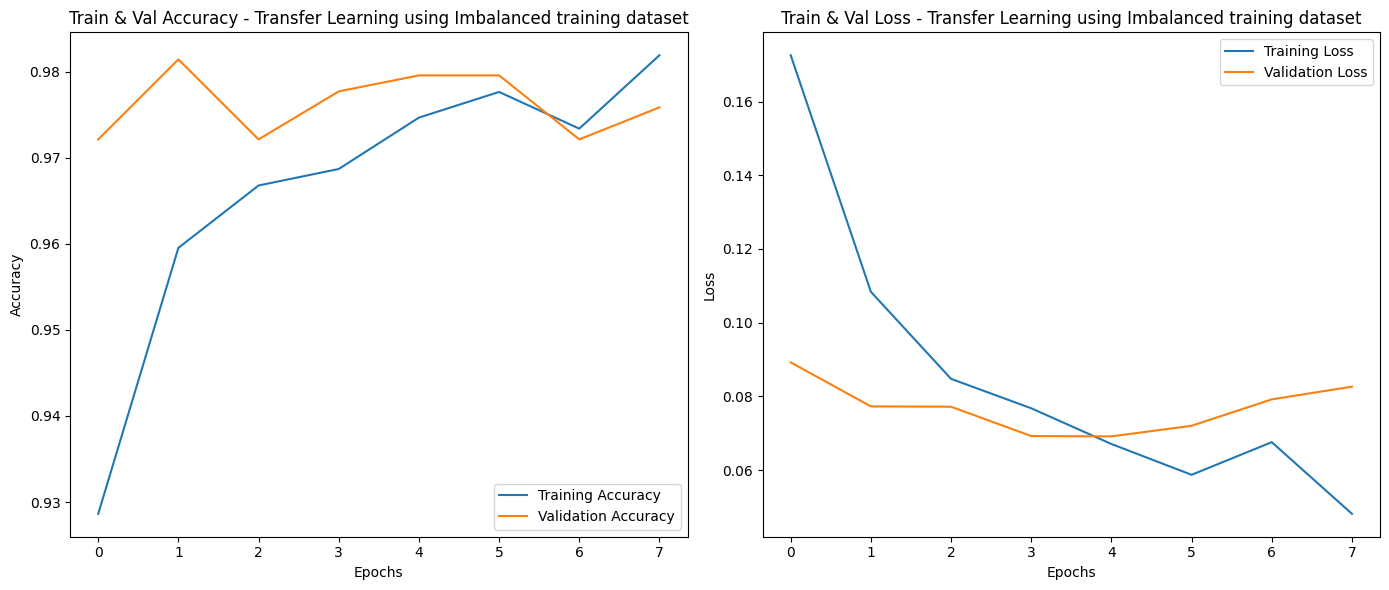

Epoch 1/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.9138 - loss: 0.2115 - val_accuracy: 0.9461 - val_loss: 0.1290 - learning_rate: 0.0010
Epoch 2/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.9727 - loss: 0.0793 - val_accuracy: 0.9647 - val_loss: 0.0994 - learning_rate: 0.0010
Epoch 3/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9723 - loss: 0.0745 - val_accuracy: 0.9796 - val_loss: 0.0812 - learning_rate: 0.0010
Epoch 4/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 59ms/step - accuracy: 0.9759 - loss: 0.0662 - val_accuracy: 0.9331 - val_loss: 0.1677 - learning_rate: 0.0010
Epoch 5/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 60ms/step - accuracy: 0.9817 - loss: 0.0532 - val_accuracy: 0.9442 - val_loss: 0.1284 - learning_rate: 0.0010
Epoch 6/50
218/218 ━━━━━━━━━━━━━━━━━━━━ 13s 58ms/step - accuracy: 0.9776 - loss: 0.0603 - val_accuracy: 0.9647 - val_loss: 0.0945 - learning_rate: 0.0010
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step

Classification Report for Transfer 

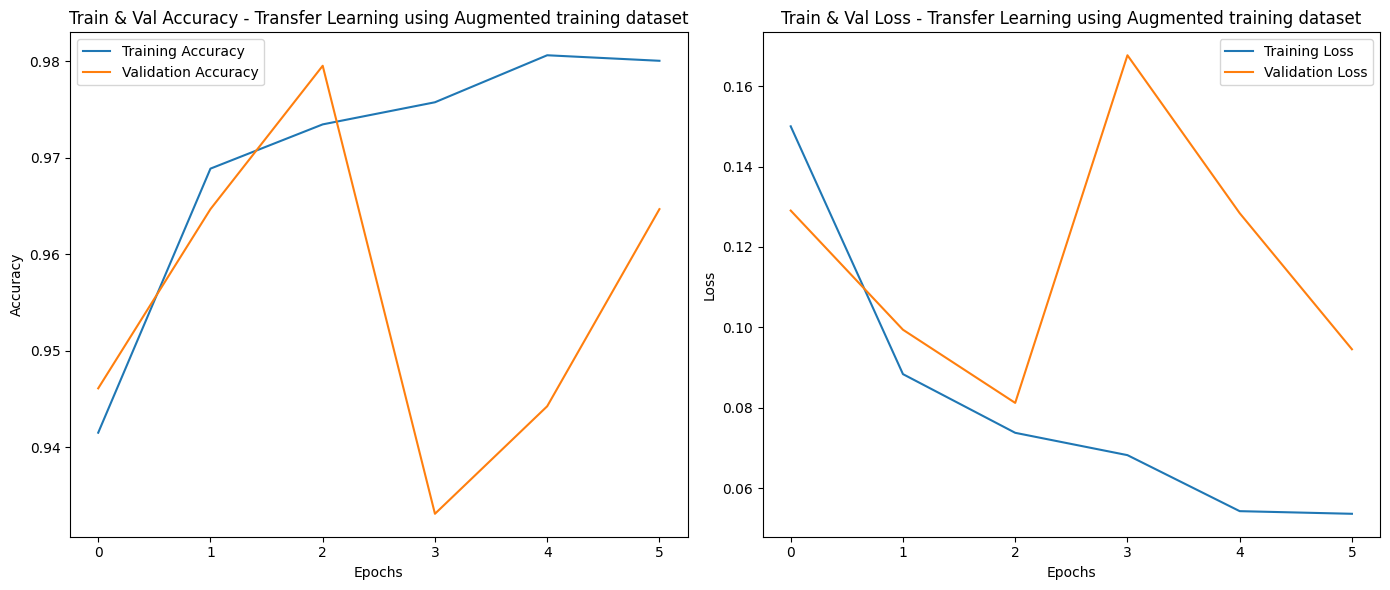

Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - accuracy: 0.8506 - loss: 0.3213 - val_accuracy: 0.9535 - val_loss: 0.1151 - learning_rate: 0.0010
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 69ms/step - accuracy: 0.9561 - loss: 0.1237 - val_accuracy: 0.9740 - val_loss: 0.0828 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9667 - loss: 0.0893 - val_accuracy: 0.9740 - val_loss: 0.0819 - learning_rate: 0.0010
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9629 - loss: 0.0927 - val_accuracy: 0.9517 - val_loss: 0.1035 - learning_rate: 0.0010
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.9744 - loss: 0.0725 - val_accuracy: 0.9814 - val_loss: 0.0705 - learning_rate: 0.0010
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.9845 - loss: 0.0508 - val_accuracy: 0.9628 - val_loss: 0.0814 - learning_rate: 0.0010
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.9822 - loss: 0.0507 - val_acc

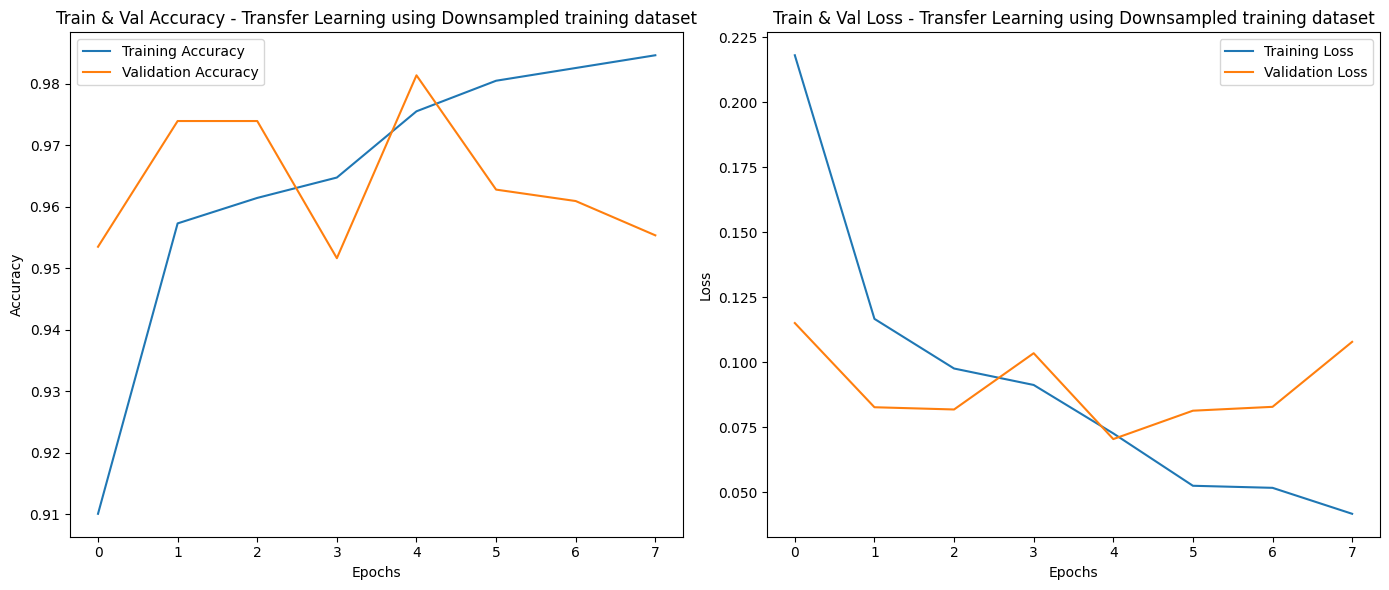

In [89]:
# Transfer Learning

input_shape = (128, 128, 3)  # MobileNetV2 expects 3 channels
epochs = 50

transfer_model = build_transfer_model(input_shape)
print(transfer_model.summary())
transfer_info, history, cf_info = train_and_evaluate_dl(transfer_model, X_train_rgb, X_val_rgb, X_test_rgb, y_train, y_val, y_test, "Transfer Learning", "Imbalanced", le, epochs)
nn_metrics_info.append(transfer_info)
imbalanced_cf_info.append(cf_info)
plot_training_history(history, "Transfer Learning", "Imbalanced")

transfer_model = build_transfer_model(input_shape)
transfer_info, history, cf_info = train_and_evaluate_dl(transfer_model, X_train_augmented_rgb, X_val_rgb, X_test_rgb, y_train_augmented, y_val, y_test, "Transfer Learning", "Augmented", le, epochs)
nn_metrics_info.append(transfer_info)
augmented_cf_info.append(cf_info)
plot_training_history(history, "Transfer Learning", "Augmented")

transfer_model = build_transfer_model(input_shape)
transfer_info, history, cf_info = train_and_evaluate_dl(transfer_model, X_train_downsampled_rgb, X_val_rgb, X_test_rgb, y_train_downsampled, y_val, y_test, "Transfer Learning", "Downsampled", le, epochs)
nn_metrics_info.append(transfer_info)
downsampled_cf_info.append(cf_info)
plot_training_history(history, "Transfer Learning", "Downsampled")

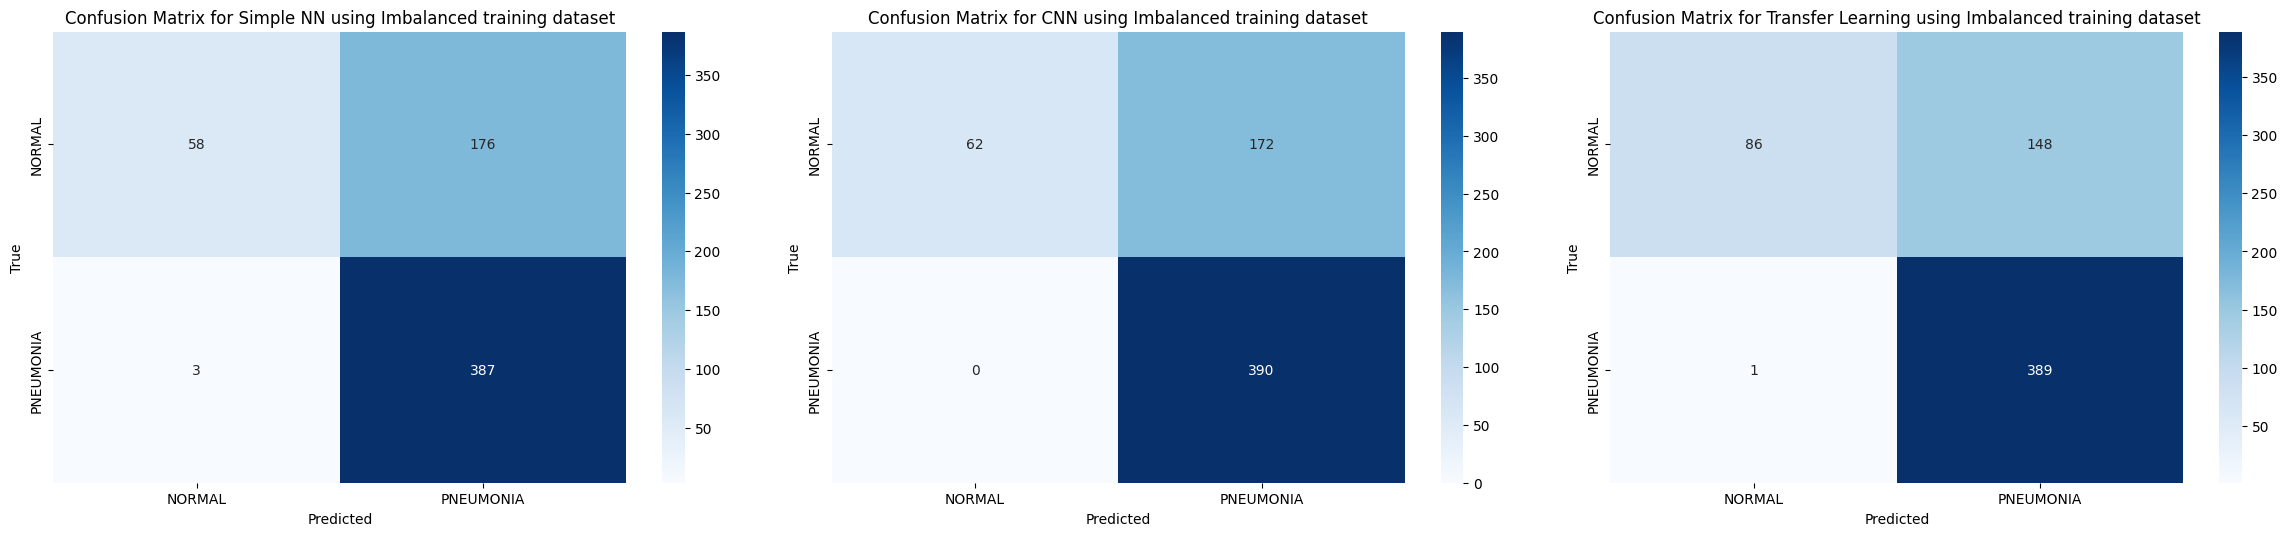

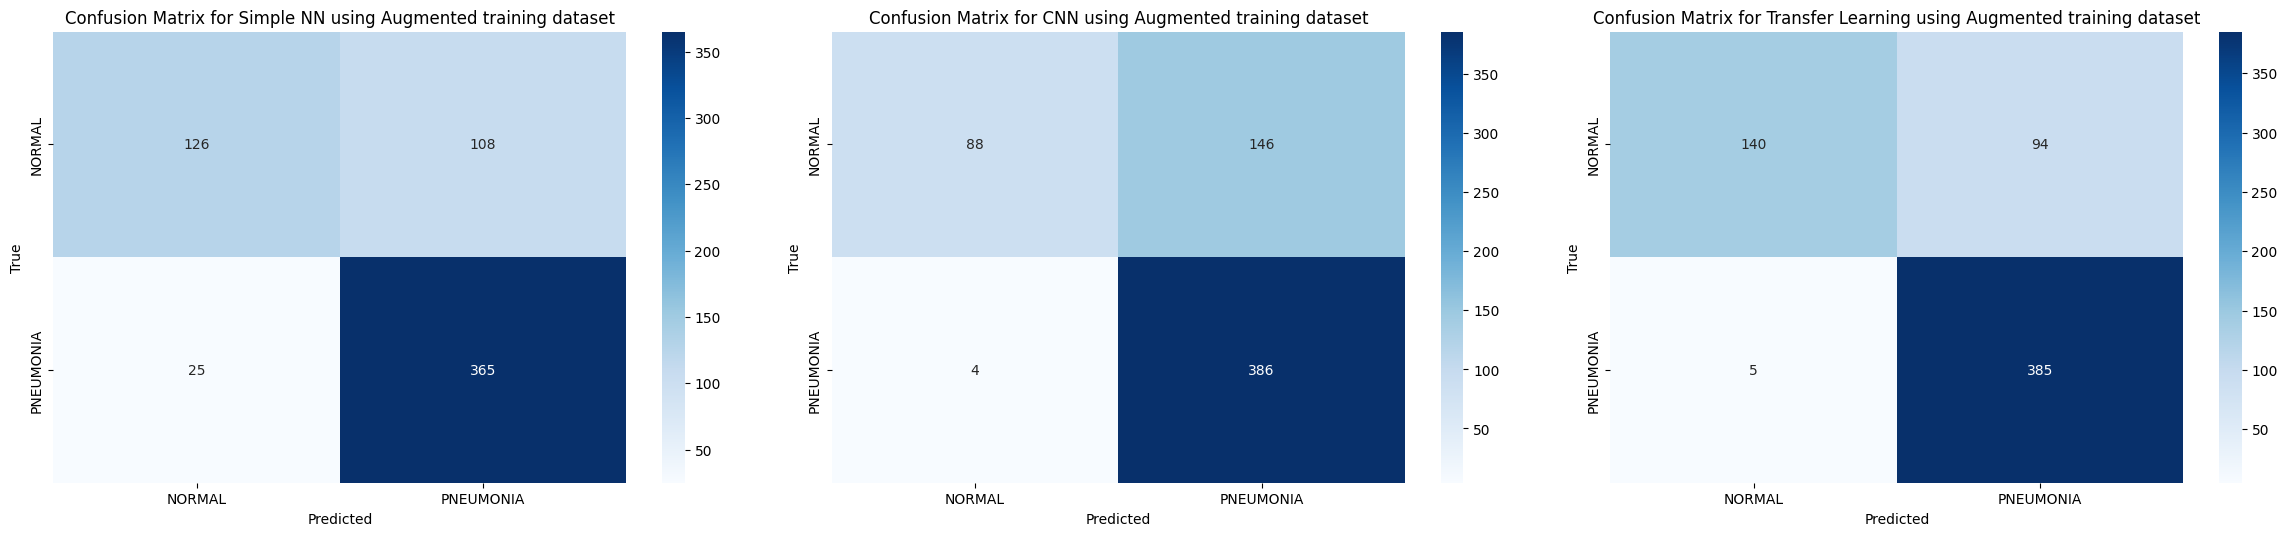

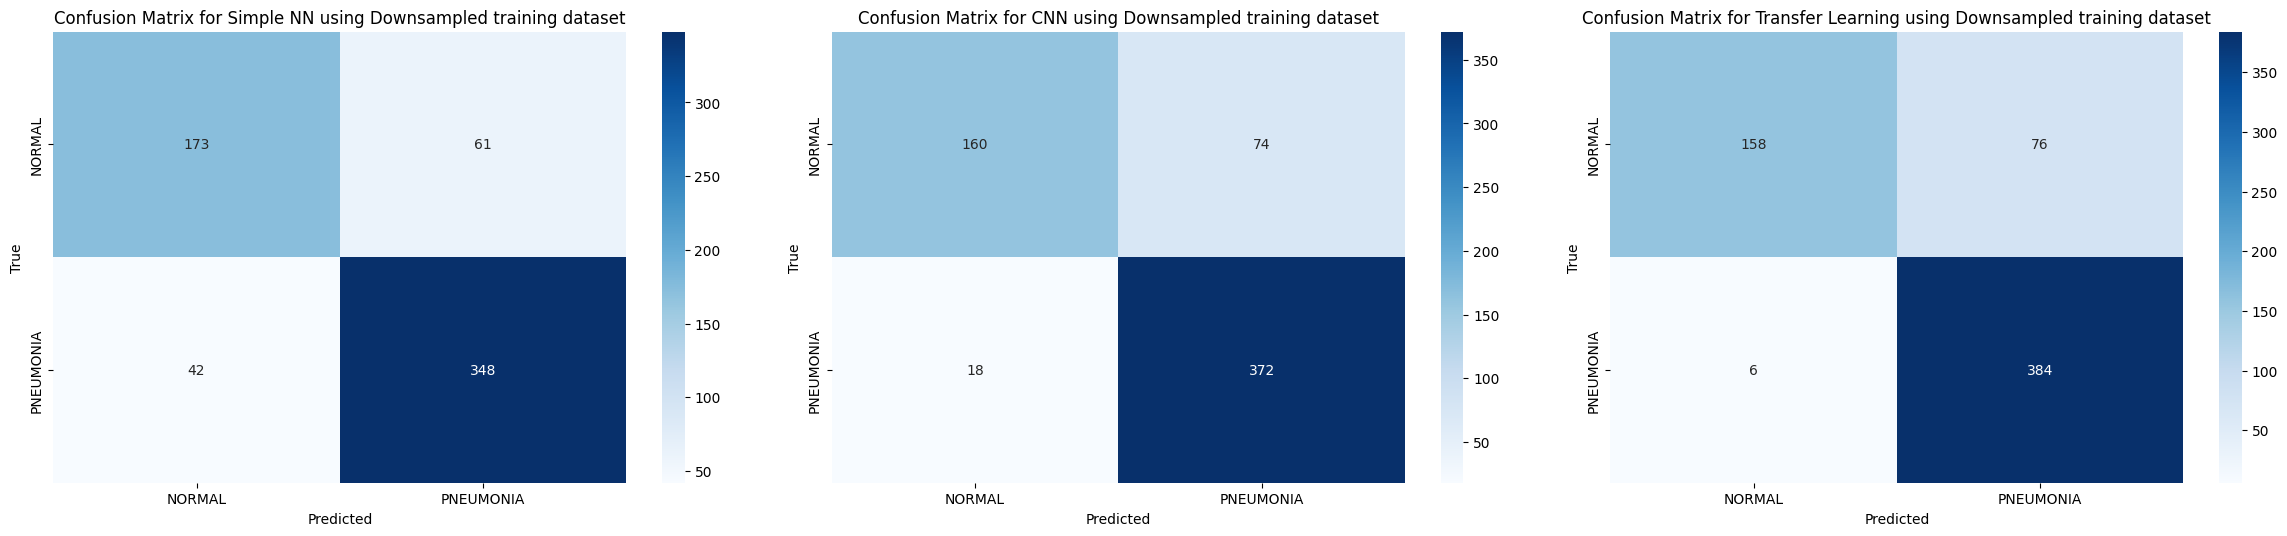

In [94]:
plot_all_cfs(imbalanced_cf_info, 1, 3)
plot_all_cfs(augmented_cf_info, 1, 3)
plot_all_cfs(downsampled_cf_info, 1, 3)

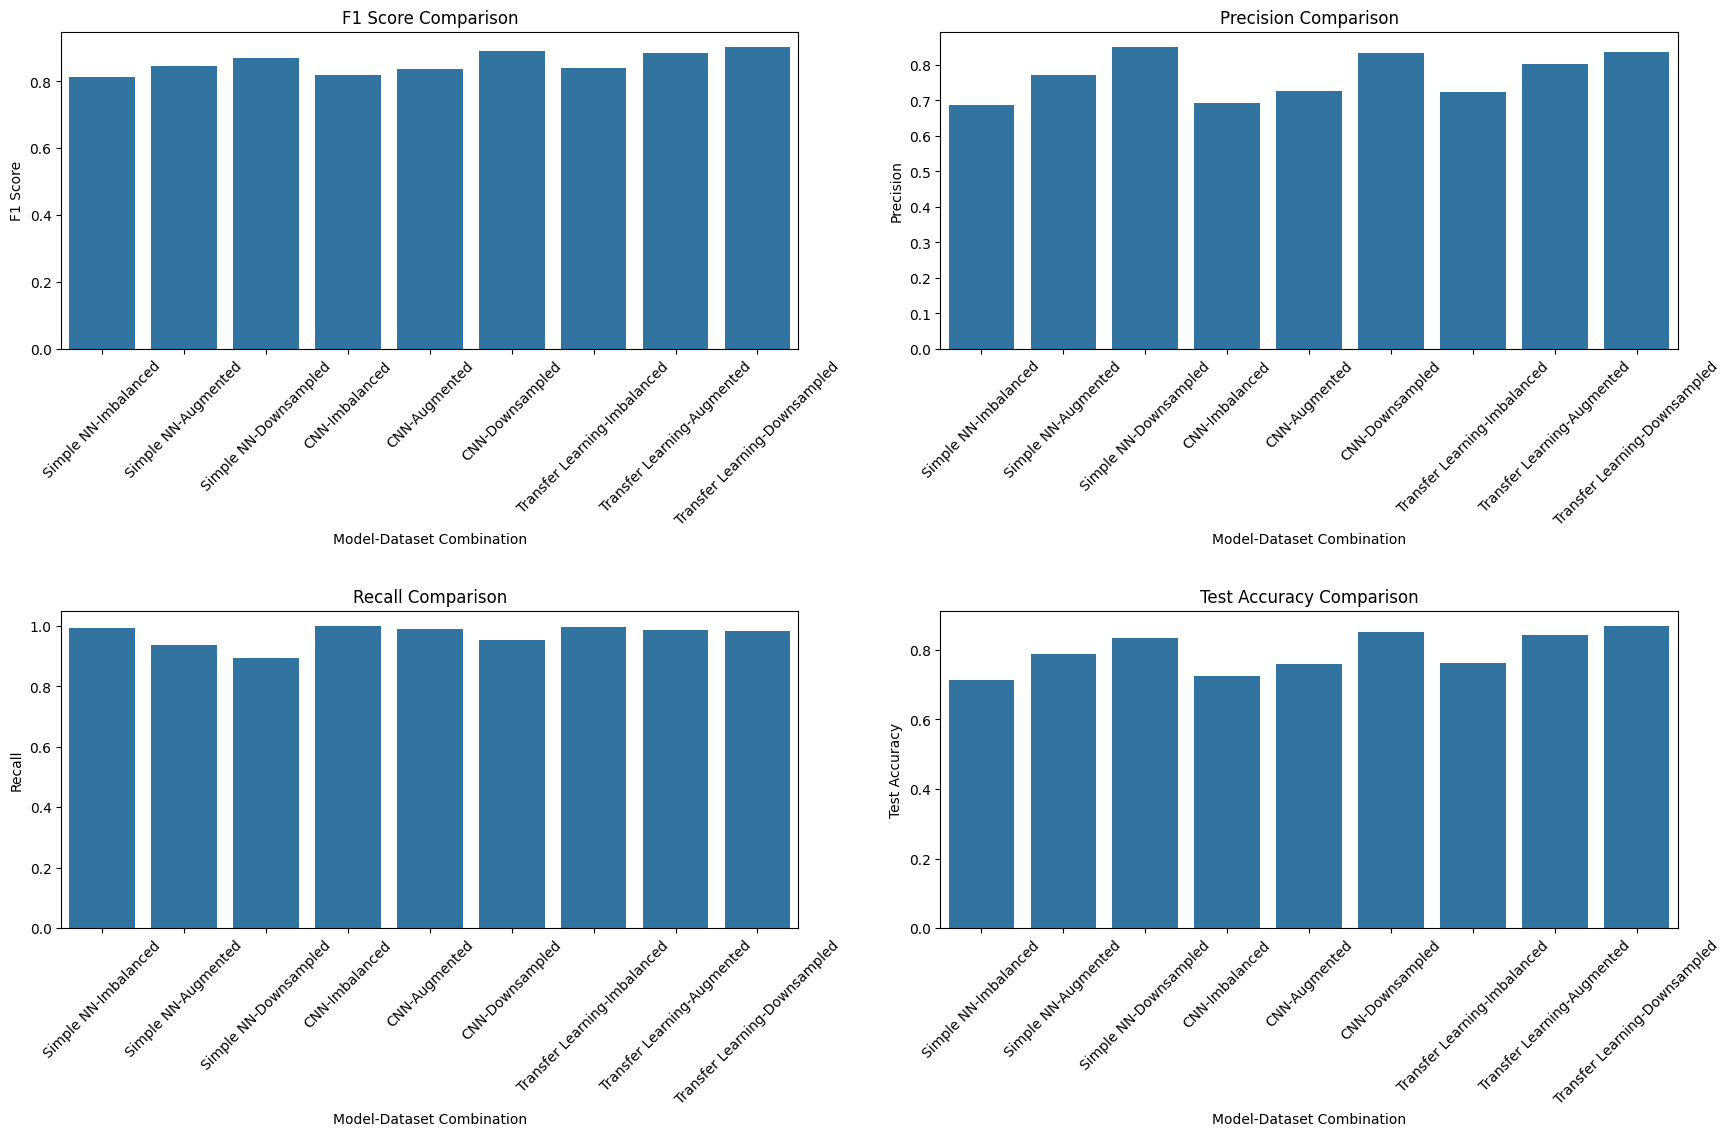

In [95]:
plot_nn_model_comparisons(nn_metrics_info)

In [96]:
nn_metrics_info_df = pd.DataFrame(nn_metrics_info)
display(nn_metrics_info_df)

,model,features,dataset,f1_score,precision,recall,test_accuracy,train_time
0,Simple NN,N/A,Imbalanced,0.812172,0.687389,0.992308,0.713141,4.563915
1,Simple NN,N/A,Augmented,0.845886,0.771670,0.935897,0.786859,7.492651
2,Simple NN,N/A,Downsampled,0.871089,0.850856,0.892308,0.834936,1.486897
3,CNN,N/A,Imbalanced,0.819328,0.693950,1.000000,0.724359,18.263926
4,CNN,N/A,Augmented,0.837310,0.725564,0.989744,0.759615,17.000019
5,CNN,N/A,Downsampled,0.889952,0.834081,0.953846,0.852564,6.331979
6,Transfer Learning,N/A,Imbalanced,0.839266,0.724395,0.997436,0.761218,54.878804
7,Transfer Learning,N/A,Augmented,0.886076,0.803758,0.987179,0.841346,78.620733
8,Transfer Learning,N/A,Downsampled,0.903529,0.834783,0.984615,0.868590,42.404078


**Simple NN**:
* Imbalanced: The model has high recall (0.99) but lower precision (0.69), indicating it predicts most pneumonia cases correctly but also generates more false positives for pneumonia.
* Augmented: Both precision (0.77) and recall (0.94) improved, leading to a higher F1 score (0.85) and accuracy (0.79). Augmentation helps the model generalize better.
* Downsampled: Achieved the best balance with an F1 score of 0.87, precision of 0.85, and recall of 0.89. Downsampling provides a more balanced training set, improving overall performance.
  
**CNN**:
* Imbalanced: Similar to the Simple NN, CNN has high recall (1.00) but lower precision (0.69), leading to moderate accuracy (0.72).
* Augmented: Precision (0.73) and recall (0.99) improved, with a balanced F1 score (0.84). Augmentation enhanced the model's performance slightly.
* Downsampled: CNN performed best with the downsampled dataset, showing the highest F1 score (0.89) and accuracy (0.85), indicating effective learning with a balanced dataset.
  
**Transfer Learning**:
* Imbalanced: Achieved high recall (0.99) and moderate precision (0.72), with an F1 score of 0.84 and accuracy of 0.76. Even with an imbalanced dataset, transfer learning benefits from pretrained features.
* Augmented: Precision (0.80) and recall (0.99) improved, leading to a high F1 score (0.89) and accuracy (0.84). Augmentation further enhances the transfer learning model's performance.
* Downsampled: Showed the best overall performance with an F1 score of 0.90, precision of 0.83, and recall of 0.98, with accuracy (0.87). The pretrained model significantly benefits from balanced training data, maintaining high recall and improving precision.

# Summary

In [104]:
summary_df = pd.concat([nn_metrics_info_df, clasic_ml_metrics_info_df], ignore_index=True)
display(summary_df.sort_values(by=['f1_score'], ascending=False))

,model,features,dataset,f1_score,precision,recall,test_accuracy,train_time
8,Transfer Learning,N/A,Downsampled,0.903529,0.834783,0.984615,0.868590,42.404078
5,CNN,N/A,Downsampled,0.889952,0.834081,0.953846,0.852564,6.331979
7,Transfer Learning,N/A,Augmented,0.886076,0.803758,0.987179,0.841346,78.620733
2,Simple NN,N/A,Downsampled,0.871089,0.850856,0.892308,0.834936,1.486897
1,Simple NN,N/A,Augmented,0.845886,0.771670,0.935897,0.786859,7.492651
6,Transfer Learning,N/A,Imbalanced,0.839266,0.724395,0.997436,0.761218,54.878804
4,CNN,N/A,Augmented,0.837310,0.725564,0.989744,0.759615,17.000019
3,CNN,N/A,Imbalanced,0.819328,0.693950,1.000000,0.724359,18.263926
0,Simple NN,N/A,Imbalanced,0.812172,0.687389,0.992308,0.713141,4.563915
17,SVM,HOG Features,downsampled,0.750150,0.841844,0.735043,0.794872,3.536190


**Comparison of Classic Machine Learning Models with Neural Network Models**

**Impact of the Training Dataset**

**Balanced vs. Imbalanced Datasets:**
* Imbalanced datasets typically led to high recall but lower precision and overall F1 scores for both classic ML and neural network models, as they struggled with minority class prediction.
* Augmented datasets improved overall performance across most models, increasing F1 scores and test accuracy.
* Downsampled datasets provided the best results for most models by balancing class representation, leading to the highest precision, recall, and F1 scores, reflecting more reliable performance across classes.

**Training Times:**

Transfer Learning models required the most time due to the complexity of fine-tuning a pretrained architecture, CNNs had moderate training times, Simple NNs were relatively fast, while Classic ML models had short training times.

**Model Performance Summary**
* Transfer Learning (MobileNetV2):
Best Performance: Achieved the highest F1 score (0.90), precision (0.83), recall (0.98), and test accuracy (0.87) on the downsampled dataset.
It performs well across all datasets, leveraging pretrained features. .

* CNN:
Second Best: High F1 score (0.89), precision (0.83), and recall (0.95) on the downsampled dataset.
It demonstrates good performance on augmented and downsampled datasets, benefiting from its ability to learn spatial features. 

* Simple Neural Network (NN):
Achieved an F1 score of 0.87, precision of 0.85, and recall of 0.89 on the downsampled dataset.
Performed well on the downsampled dataset, showing significant improvement with balanced data. It also had the fastest training times, making it computationally efficient.

* Support Vector Machine (SVM):
Best with HOG Features: Achieved an F1 score of 0.75, precision of 0.84, and recall of 0.74 on the downsampled dataset with HOG features.
SVMs performed better with HOG features than with intensity features, but generally lagged behind neural network models in F1 score and accuracy.

* Random Forest (RF):
Decent with HOG Features: Achieved an F1 score of 0.74 on the downsampled dataset with HOG features, showing reasonable balance.
It performed the worst on imbalanced datasets and did not improve significantly with augmentation or downsampling. RF struggled more with intensity features compared to HOG features.

**Best Model**

The Transfer Learning model with MobileNetV2 on the downsampled dataset stands out as the best overall performer. It combines high precision, recall, and F1 score with robust pretrained feature extraction, providing superior results in pneumonia detection compared to both classical ML and other neural network models.

Neural network models, particularly transfer learning, generally outperform classic machine learning models, especially when using downsampled datasets to balance the class distribution. 